In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

df = pd.read_csv("E:/infovis/yinchuan_tgap2.csv",
    # usecols=['lng','lat','position_time','height','icao',
    #          'icao_segment','speed','heading'],
)


df = df.dropna(subset=['position_time'])

df = df.sort_values(by='position_time')
df = df.drop_duplicates(subset='position_time')

fmt = "%Y/%m/%d %H:%M:%S"   
df['position_time_dt'] = pd.to_datetime(df['position_time'], format=fmt, errors='coerce')

#  将 datetime 转成毫秒时间戳（int64，ms）
df['position_time_dt'] = df['position_time_dt'].astype('int64') // 10**6   # int 毫秒

#  计算 dt（秒）：
df = df.sort_values(['icao_segment','position_time_dt']).reset_index(drop=True)
df['dt'] = df.groupby('icao_segment')['position_time_dt'].diff() / 1000.0   # 秒


In [17]:
df.head()


,Unnamed: 0,icao,altitude,ver_speed_type,lng,lat,height,heading,ver_speed,speed,position_time,callsign,icao_segment,position_time_dt,dt
0,182619,10496125,5105.40,0,105.119218,38.767776,5257.80,270.30804,6.82752,95.688050,2024-10-11 02:37:18.707,HL2121,10496125_1,-9223372036855,NaN
1,182576,10496125,5135.88,0,105.113586,38.767773,5250.18,270.30804,6.82752,95.688050,2024-10-11 02:37:23.928,HL2121,10496125_1,-9223372036855,0.0
2,182482,10496125,5204.46,0,105.102539,38.767819,5318.76,270.30640,6.82752,96.202484,2024-10-11 02:37:33.969,HL2121,10496125_1,-9223372036855,0.0
3,182425,10496125,5227.32,0,105.098499,38.767868,5318.76,270.30640,6.82752,96.202484,2024-10-11 02:37:37.749,HL2121,10496125_1,-9223372036855,0.0
4,182348,10496125,5295.90,0,105.087280,38.767912,5425.44,270.30475,6.50240,96.716930,2024-10-11 02:37:47.710,HL2121,10496125_1,-9223372036855,0.0


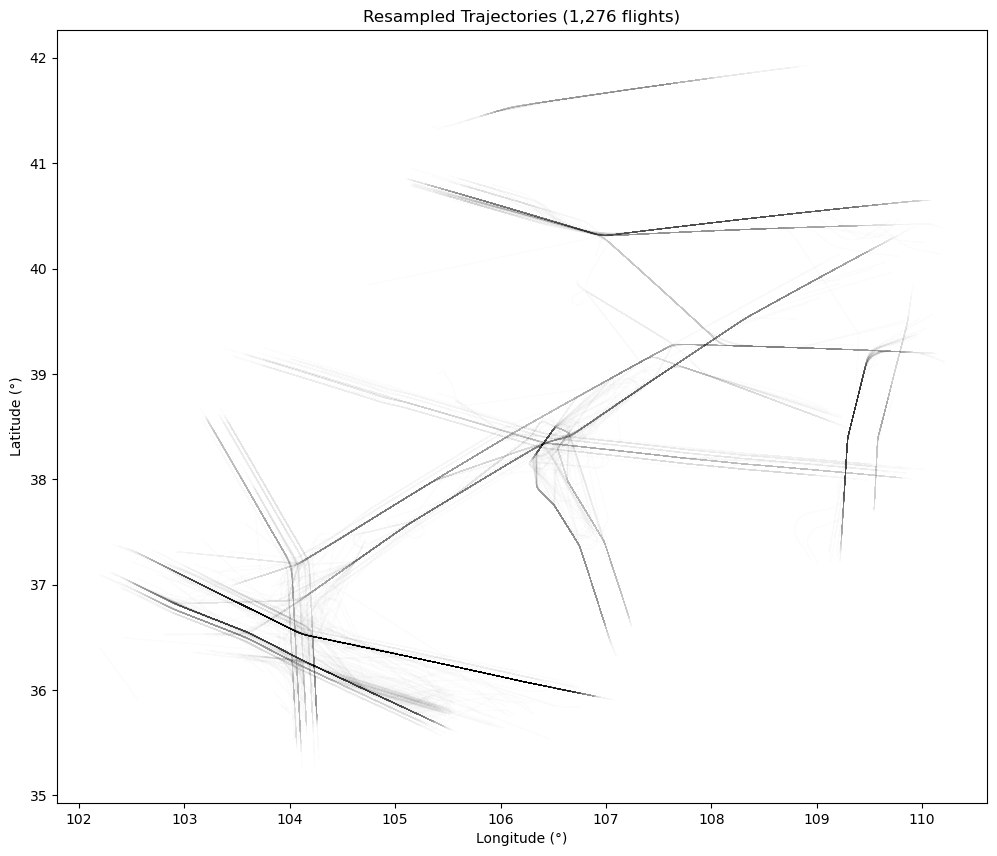

In [18]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# group once (no repeated boolean filters)
groups = df.groupby('icao_segment', sort=False)

# build list of polylines as Nx2 numpy arrays
lines = [np.column_stack((g['lng'].to_numpy(), g['lat'].to_numpy()))
         for _, g in groups if len(g) > 1]

fig, ax = plt.subplots(figsize=(12, 12))
lc = LineCollection(
    lines,
    linewidths=0.4,
    alpha=0.01,       # reduce if still slow; try removing alpha for speed
    antialiased=False,
       colors='black',  # single color is faster than colormap
)
ax.add_collection(lc)
ax.autoscale()        # fits the data bounds
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'Resampled Trajectories ({len(lines):,} flights)')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.grid(False)        # grid costs; turn off for speed
plt.show()


In [31]:

track_id = df.groupby("icao_segment").size().idxmax()
track = df[df["icao_segment"] == track_id].reset_index(drop=True)


# 经纬度 → 平面坐标
lat0 = np.radians(track["lat"].iloc[0])
lng0 = track["lng"].iloc[0]
m_per_deg_lat = 111000
m_per_deg_lng = 111000 * np.cos(lat0)

track["x"] = (track["lng"] - track["lng"].iloc[0]) * m_per_deg_lng
track["y"] = (track["lat"] - track["lat"].iloc[0]) * m_per_deg_lat

# 时间间隔 dt
#track["dt"] = track["position_time"].diff() / 1000
#track["dt"].iloc[0] = track["dt"].iloc[1]
track.loc[track.index[0], "dt"] = track.loc[track.index[1], "dt"]

# 速度分解
theta = np.deg2rad(track["heading"])
track["vx"] = track["speed"] * np.cos(theta)
track["vy"] = track["speed"] * np.sin(theta)




In [20]:
from tqdm import tqdm  # 进度条

# 确保数据已加载
print(f"数据框形状: {df.shape}")
print(f"轨迹数量 (icao_segment): {df['icao_segment'].nunique()}")


数据框形状: (103281, 15)
轨迹数量 (icao_segment): 1291


In [32]:
# 存储所有轨迹的结果
all_tracks_results = []
all_smoothed_results = []
all_mse_values = []

# 用于汇总统计
track_summary = []

# 设置最小轨迹长度阈值
MIN_TRACK_LENGTH = 5

# 处理每条轨迹
for track_id, track_group in tqdm(df.groupby("icao_segment"), desc="处理轨迹"):
    track = track_group.reset_index(drop=True)
    
    # 跳过太短的轨迹
    if len(track) < MIN_TRACK_LENGTH:
        continue
    
    try:
        # ==================================================
        # 卡尔曼滤波处理（与之前代码相同）
        # ==================================================
        # 保存原始经latitude用于后续转换
        lat0 = track["lat"].iloc[0]
        lng0 = track["lng"].iloc[0]
        lat0_rad = np.radians(lat0)
        
        # 经latitude → 平面坐标转换参数
        m_per_deg_lat = 111000
        m_per_deg_lng = 111000 * np.cos(lat0_rad)
        
        # 平面坐标转换
        track["x"] = (track["lng"] - lng0) * m_per_deg_lng
        track["y"] = (track["lat"] - lat0) * m_per_deg_lat
        
        # 时间间隔 dt
        if "dt" in track.columns:
            track["dt"] = track["dt"].bfill()
        else:
            track["dt"] = track["position_time"].diff() / 1000
            track["dt"].iloc[0] = track["dt"].iloc[1]
        
        # 速度分解
        theta = np.deg2rad(track["heading"])
        track["vx"] = track["speed"] * np.cos(theta)
        track["vy"] = track["speed"] * np.sin(theta)
        
        # 卡尔曼滤波器
        kf = KalmanFilter(dim_x=2, dim_z=2)
        kf.F = np.array([[1, 0], [0, 1]])
        kf.H = np.eye(2)
        kf.P *= 10
        kf.R = np.eye(2) * 25
        kf.Q = np.eye(2) * 1
        kf.x = np.array([[track["x"].iloc[0]], [track["y"].iloc[0]]])
        
        # 运行卡尔曼滤波
        xs, ys = [], []
        for i in range(len(track)):
            dt = track["dt"].iloc[i]
            kf.B = np.array([[dt, 0], [0, dt]])
            u = np.array([[track["vx"].iloc[i]], [track["vy"].iloc[i]]])
            kf.predict(u=u)
            z = np.array([track["x"].iloc[i], track["y"].iloc[i]])
            kf.update(z)
            xs.append(kf.x[0, 0])
            ys.append(kf.x[1, 0])
        
        # 将平滑后的坐标转换回经latitude
        lng_smoothed = lng0 + np.array(xs) / m_per_deg_lng
        lat_smoothed = lat0 + np.array(ys) / m_per_deg_lat
        
        # 计算RMSE
        n_points = min(len(xs), len(track["x"]))
        if n_points > 0:
            xs_smoothed = xs[:n_points]
            ys_smoothed = ys[:n_points]
            x_true = track["x"].values[:n_points]
            y_true = track["y"].values[:n_points]
            
            point_errors = (xs_smoothed - x_true)**2 + (ys_smoothed - y_true)**2
            mse = np.mean(point_errors)
            
            # 保存结果
            all_mse_values.append(mse)
            
            # 保存轨迹数据（用于可视化）
            track_data = {
                'track_id': track_id,
                'lng_original': track["lng"].values[:n_points],
                'lat_original': track["lat"].values[:n_points],
                'lng_smoothed': lng_smoothed[:n_points],
                'lat_smoothed': lat_smoothed[:n_points],
                'mse': mse,
                'length': n_points
            }
            
            # 添加到汇总
            track_summary.append({
                'track_id': track_id,
                'length': n_points,
                'mse': mse,
                'start_lat': track["lat"].iloc[0],
                'start_lng': track["lng"].iloc[0],
                'end_lat': track["lat"].iloc[-1],
                'end_lng': track["lng"].iloc[-1]
            })
            
            all_tracks_results.append(track_data)
        
    except Exception as e:
        print(f"处理轨迹 {track_id} 时出错: {str(e)}")
        continue

print(f"\n成功处理 {len(all_tracks_results)} 条轨迹")



处理轨迹: 100%|██████████| 1291/1291 [00:06<00:00, 192.38it/s]


成功处理 1230 条轨迹


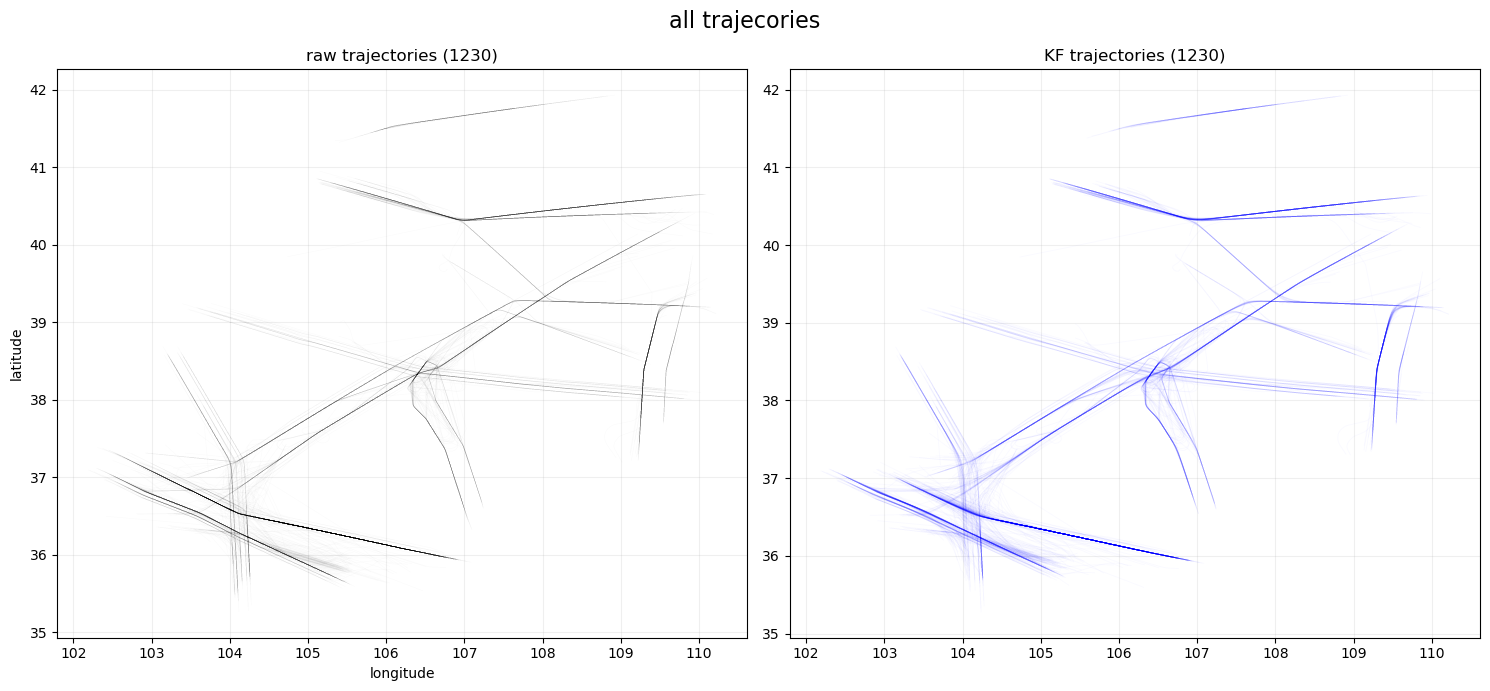

In [22]:
# ==================================================
# 可视化1：所有轨迹的原始和平滑对比（使用透明度）
# ==================================================
fig1, axes1 = plt.subplots(1, 2, figsize=(15, 7))

# 设置透明度参数
# 根据轨迹数量自动调整透明度
alpha_raw = max(0.01, 0.5 / np.sqrt(len(all_tracks_results)))
alpha_smooth = max(0.02, 0.7 / np.sqrt(len(all_tracks_results)))

# 绘制原始轨迹
ax1 = axes1[0]
for track_data in all_tracks_results:
    ax1.plot(track_data['lng_original'], track_data['lat_original'], 
             'k-', alpha=alpha_raw, linewidth=0.5)
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_title(f'raw trajectories ({len(all_tracks_results)})')
ax1.grid(True, alpha=0.2)

# 绘制平滑轨迹
ax2 = axes1[1]
for track_data in all_tracks_results:
    ax2.plot(track_data['lng_smoothed'], track_data['lat_smoothed'], 
             'b-', alpha=alpha_smooth, linewidth=0.7)
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax2.set_title(f'KF trajectories ({len(all_tracks_results)})')
ax2.grid(True, alpha=0.2)

plt.suptitle('all trajecories', fontsize=16)
plt.tight_layout()
plt.show()




Selected 100 baseline trajectories
  Length range: [105, 304]
  MSE range: [9643442.3143, 67630152.8960]

Top 100 trajectories by MSE (best smoothing performance):
  MSE range: [9643442.3143, 67630152.8960]
  Average MSE: 41765823.8578

Extracted 100 baseline trajectories

Visualizing top 10 baseline trajectories...


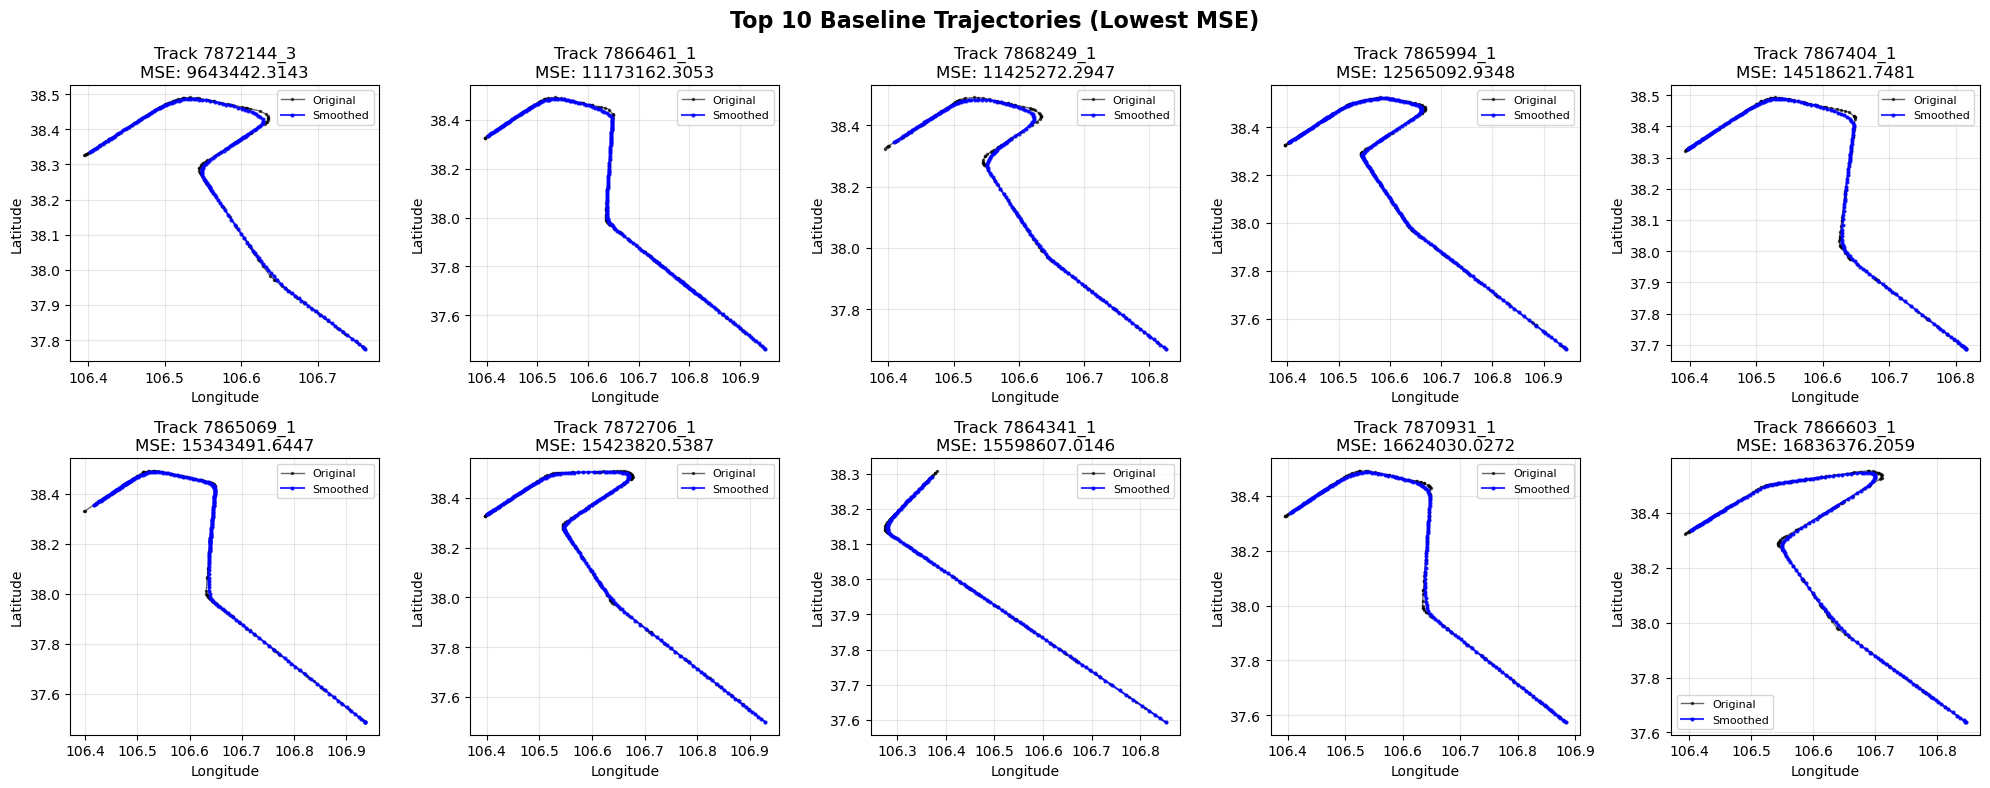

In [23]:
# baseline 生成
#
mse_df = pd.DataFrame({
    'track_id': [track['track_id'] for track in track_summary],
    'mse': [track['mse'] for track in track_summary],
    'length': [track['length'] for track in track_summary]
})
MIN_LENGTH = 100
N_BASELINE = 100

mse_df_filtered = mse_df[mse_df['length'] > MIN_LENGTH].reset_index(drop=True)

if len(mse_df_filtered) < N_BASELINE:
    print(f"⚠️ Warning: only {len(mse_df_filtered)} tracks with length > {MIN_LENGTH}")
    top_100_mse_tracks = mse_df_filtered.sort_values('mse').copy()
else:
    top_100_mse_tracks = (
        mse_df_filtered
        .sort_values(by='mse', ascending=True)
        .head(N_BASELINE)
        .reset_index(drop=True)
    )

print(f"\nSelected {len(top_100_mse_tracks)} baseline trajectories")
print(f"  Length range: [{top_100_mse_tracks['length'].min()}, {top_100_mse_tracks['length'].max()}]")
print(f"  MSE range: [{top_100_mse_tracks['mse'].min():.4f}, {top_100_mse_tracks['mse'].max():.4f}]")

# 升序
mse_df_sorted = mse_df_filtered.sort_values(by='mse', ascending=True).reset_index(drop=True)
# 选取前100条轨迹
top_100_mse_tracks = mse_df_sorted.head(100)
print(f"\nTop 100 trajectories by MSE (best smoothing performance):")
print(f"  MSE range: [{top_100_mse_tracks['mse'].min():.4f}, {top_100_mse_tracks['mse'].max():.4f}]")
print(f"  Average MSE: {top_100_mse_tracks['mse'].mean():.4f}")

# 提取baseline轨迹数据
baseline_tracks = []
for track_id in top_100_mse_tracks['track_id']:
    # 在all_tracks_results中找到对应的轨迹
    for track_data in all_tracks_results:
        if track_data['track_id'] == track_id:
            baseline_tracks.append(track_data)
            break

print(f"\nExtracted {len(baseline_tracks)} baseline trajectories")

# ==================================================
# 可视化MSE分布和baseline选择
# ==================================================

print("\nVisualizing top 10 baseline trajectories...")

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(min(10, len(baseline_tracks))):
    track_data = baseline_tracks[i]
    ax = axes[i]
    
    # 绘制原始轨迹
    ax.plot(track_data['lng_original'], track_data['lat_original'], 'k.-', 
           alpha=0.6, markersize=3, linewidth=1, label='Original')
    
    # 绘制平滑轨迹
    ax.plot(track_data['lng_smoothed'], track_data['lat_smoothed'], 'b.-', 
           alpha=0.8, markersize=4, linewidth=1.5, label='Smoothed')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Track {track_data["track_id"]}\nMSE: {track_data["mse"]:.4f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# 隐藏多余的子图
for i in range(min(10, len(baseline_tracks)), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Top 10 Baseline Trajectories (Lowest MSE)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [24]:
baseline_rows = []

for track_data in baseline_tracks:
    track_id = track_data['track_id']
    mse = track_data['mse']
    
    lngs = track_data['lng_original']
    lats = track_data['lat_original']
    
    for i, (lng, lat) in enumerate(zip(lngs, lats)):
        baseline_rows.append({
            'track_id': track_id,
            'point_idx': i,
            'lng_original': lng,
            'lat_original': lat,
            'lng_smoothed': track_data['lng_smoothed'][i],
            'lat_smoothed': track_data['lat_smoothed'][i],
            'mse': mse
        })

baseline_df = pd.DataFrame(baseline_rows)

# 保存
save_path = 'baseline_kf_top100.csv'
baseline_df.to_csv(save_path, index=False)

print(f"Baseline original trajectories saved to: {save_path}")
print(baseline_df.head())


Baseline original trajectories saved to: baseline_kf_top100.csv
    track_id  point_idx  lng_original  lat_original  lng_smoothed  \
0  7872144_3          0    106.761923     37.775620    106.761923   
1  7872144_3          1    106.757364     37.783218    106.760752   
2  7872144_3          2    106.751284     37.793295    106.758585   
3  7872144_3          3    106.736298     37.817967    106.753862   
4  7872144_3          4    106.732118     37.824810    106.749487   

   lat_smoothed           mse  
0     37.775620  9.643442e+06  
1     37.777571  9.643442e+06  
2     37.781170  9.643442e+06  
3     37.788967  9.643442e+06  
4     37.796179  9.643442e+06  


In [25]:
#  加载baseline轨迹数据
baseline_df = pd.read_csv(save_path)
print(f"Loaded {len(baseline_df)} baseline trajectories")

Loaded 19310 baseline trajectories


In [33]:
# 添加噪声
# Adds noise/drift/spikes

import numpy as np
from scipy.spatial.distance import cdist

def normalize_trajectory(xy_data, global_min=None, global_max=None):
    """
    将轨迹坐标归一化到[0,1]范围
    
    参数:
    xy_data: numpy数组，形状为(n, 2)，表示2D轨迹点
    global_min: 全局最小值，如果为None则从当前数据计算
    global_max: 全局最大值，如果为None则从当前数据计算
    
    返回:
    normalized_data: 归一化后的数据
    min_vals: 最小值
    max_vals: 最大值
    """
    if global_min is None or global_max is None:
        min_vals = np.min(xy_data, axis=0)
        max_vals = np.max(xy_data, axis=0)
    else:
        min_vals = global_min
        max_vals = global_max
    
    # 避免除零
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1.0
    
    # 归一化到[0,1]
    normalized_data = (xy_data - min_vals) / range_vals
    
    return normalized_data, min_vals, max_vals

def denormalize_trajectory(normalized_data, min_vals, max_vals):
    """ 
    将归一化坐标反归一化回原始范围
    
    参数:
    normalized_data: 归一化后的数据
    min_vals: 最小值
    max_vals: 最大值
    
    返回:
    反归一化后的数据
    """
    range_vals = max_vals - min_vals
    denormalized_data = normalized_data * range_vals + min_vals
    
    return denormalized_data

def add_noise_normalized(xy: np.ndarray, T: int,
                         noise_std: float = 0.003,
                         drift_mag: float = 0.00,
                         spike_prob: float = 0.00,
                         spike_scale: float = 4.0,
                         seed: int = 42,
                         clamp: bool = True):
    """
    在归一化空间[0,1]中添加噪声
    
    参数:
    xy: (n, 2T) 归一化后的轨迹，在[0,1]范围内
    noise_std: 高斯噪声的标准差（归一化单位）
    drift_mag: 每个轨迹的恒定漂移幅度（归一化单位）
    spike_prob: 每个样本出现尖峰的概率（0..1）
    spike_scale: 尖峰噪声相对于noise_std的倍数
    """
    rng = np.random.default_rng(seed)
    n = xy.shape[0]
    lon = xy[:, :T].copy()
    lat = xy[:, T:].copy()

    # Gaussian jitter
    ex = rng.normal(0.0, noise_std, size=lon.shape).astype(np.float32)
    ey = rng.normal(0.0, noise_std, size=lat.shape).astype(np.float32)

    # Constant drift (random direction, same across T)
    if drift_mag != 0.0:
        drift_dir = rng.normal(0.0, 1.0, size=(n, 2)).astype(np.float32)
        drift_dir /= (np.linalg.norm(drift_dir, axis=1, keepdims=True) + 1e-9)
        dx = (drift_dir[:, 0:1] * drift_mag).repeat(T, axis=1)
        dy = (drift_dir[:, 1:2] * drift_mag).repeat(T, axis=1)
        ex += dx
        ey += dy

    # Sparse spikes
    if spike_prob > 0.0:
        spikes = rng.random(lon.shape) < spike_prob
        ex += spikes * rng.normal(0.0, spike_scale * max(noise_std, 1e-9), size=lon.shape)
        ey += spikes * rng.normal(0.0, spike_scale * max(noise_std, 1e-9), size=lat.shape)

    lon_noisy = lon + ex
    lat_noisy = lat + ey

    if clamp:
        lon_noisy = np.clip(lon_noisy, 0.0, 1.0)
        lat_noisy = np.clip(lat_noisy, 0.0, 1.0)

    noisy = np.concatenate([lon_noisy, lat_noisy], axis=1).astype(np.float32, copy=False)
    return noisy

def add_noise_to_trajectory(trajectory_points, 
                           noise_type='gaussian', 
                           noise_level=0.003,
                           drift_magnitude=0.005,
                           spike_probability=0.01,
                           spike_scale=4.0,
                           seed=42):
    """
    为单个轨迹添加噪声
    
    参数:
    trajectory_points: numpy数组，形状为(n, 2)，表示2D轨迹点
    noise_type: 噪声类型 ('gaussian', 'drift', 'spike', 'mixed')
    noise_level: 噪声水平（高斯噪声的标准差）
    drift_magnitude: 漂移幅度
    spike_probability: 尖峰概率
    spike_scale: 尖峰噪声倍数
    
    返回:
    noisy_trajectory: 添加噪声后的轨迹
    """
    # 归一化轨迹坐标到[0,1]
    normalized_points, min_vals, max_vals = normalize_trajectory(trajectory_points)
    
    T = len(trajectory_points)
    #n = 1  # 单个轨迹
    
    # 准备输入数据：形状为(1, 2T)
    xy_input = np.concatenate([normalized_points[:, 0].reshape(1, -1), 
                              normalized_points[:, 1].reshape(1, -1)], axis=1)
    
    # 根据噪声类型设置参数
    if noise_type == 'gaussian':
        noisy_normalized = add_noise_normalized(xy_input, T, noise_std=noise_level, seed=seed)
    elif noise_type == 'drift':
        noisy_normalized = add_noise_normalized(xy_input, T, noise_std=0.0, 
                                               drift_mag=drift_magnitude, seed=seed)
    elif noise_type == 'spike':
        noisy_normalized = add_noise_normalized(xy_input, T, noise_std=0.0,
                                               spike_prob=spike_probability,
                                               spike_scale=spike_scale, seed=seed)
    elif noise_type == 'mixed':
        noisy_normalized = add_noise_normalized(xy_input, T, 
                                               noise_std=noise_level,
                                               drift_mag=drift_magnitude,
                                               spike_prob=spike_probability,
                                               spike_scale=spike_scale, seed=seed)
    else:
        raise ValueError(f"Unsupported noise type: {noise_type}")
    
    # 从噪声数据中提取x和y
    x_noisy_normalized = noisy_normalized[0, :T]
    y_noisy_normalized = noisy_normalized[0, T:]
    
    # 反归一化
    x_noisy = denormalize_trajectory(x_noisy_normalized.reshape(-1, 1), 
                                     min_vals[0], max_vals[0]).flatten()
    y_noisy = denormalize_trajectory(y_noisy_normalized.reshape(-1, 1), 
                                     min_vals[1], max_vals[1]).flatten()
    
    # 组合成轨迹点
    noisy_trajectory = np.column_stack([x_noisy, y_noisy])
    
    return noisy_trajectory

def add_noise_to_all_baselines_df(
    baseline_df,
    noise_type='gaussian',
    noise_level=0.003,
    drift_magnitude=0.005,
    spike_probability=0.01,
    spike_scale=4.0,
    seed=42
):
    noisy_rows = []

    for i, (track_id, group) in enumerate(baseline_df.groupby('track_id')):
        group = group.sort_values('point_idx')

        trajectory_points = group[['lng_original', 'lat_original']].values

        noisy_points = add_noise_to_trajectory(
            trajectory_points,
            noise_type=noise_type,
            noise_level=noise_level,
            drift_magnitude=drift_magnitude,
            spike_probability=spike_probability,
            spike_scale=spike_scale,
            seed=seed + i
        )

        for k, row in group.iterrows():
            noisy_rows.append({
                'track_id': track_id,
                'point_idx': row['point_idx'],
                'lng_original': row['lng_original'],
                'lat_original': row['lat_original'],
                'lng_smoothed': row['lng_smoothed'],
                'lat_smoothed': row['lat_smoothed'],
                'lng_noisy': noisy_points[row['point_idx'], 0],
                'lat_noisy': noisy_points[row['point_idx'], 1],
                'noise_type': noise_type,
                'noise_level': noise_level,
                'mse': row['mse']
            })

    return pd.DataFrame(noisy_rows)


def create_multiple_noise_scenarios(baseline_tracks, noise_scenarios=None):
    """
    创建多个噪声场景
    
    参数:
    baseline_tracks: baseline轨迹列表
    noise_scenarios: 噪声场景配置列表，每个元素是一个字典
    
    返回:
    包含所有噪声场景的字典
    """
    if noise_scenarios is None:
        # 默认噪声场景
        noise_scenarios = [
            {'name': 'low_gaussian', 'type': 'gaussian', 'level': 0.001, 'seed': 100},
            {'name': 'medium_gaussian', 'type': 'gaussian', 'level': 0.003, 'seed': 200},
            {'name': 'high_gaussian', 'type': 'gaussian', 'level': 0.01, 'seed': 300},
            {'name': 'drift_only', 'type': 'drift', 'magnitude': 0.005, 'seed': 400},
            {'name': 'spike_only', 'type': 'spike', 'probability': 0.02, 'seed': 500},
            {'name': 'mixed_low', 'type': 'mixed', 'level': 0.002, 'magnitude': 0.003, 
             'probability': 0.01, 'seed': 600},
            {'name': 'mixed_high', 'type': 'mixed', 'level': 0.005, 'magnitude': 0.008,
             'probability': 0.03, 'seed': 700}
        ]
    
    all_noisy_scenarios = {}
    
    for scenario in noise_scenarios:
        print(f"Processing noise scenario: {scenario['name']}")
        
        # 提取参数
        noise_type = scenario.get('type', 'gaussian')
        noisy_df = add_noise_to_all_baselines_df(
            baseline_df,
            noise_type=noise_type,
            noise_level=scenario.get('level',0.003),
            drift_magnitude=scenario.get('magnitude',0.005),
            spike_probability=scenario.get('probability',0.01),
            spike_scale=scenario.get('spike_scale',4.0),
            seed=scenario.get('seed',42)
        )
        # if noise_type == 'gaussian':
        #     noisy_tracks = add_noise_to_all_baselines_df(
        #         baseline_tracks, 
        #         noise_type='gaussian',
        #         noise_level=scenario.get('level', 0.003),
        #         seed=scenario.get('seed', 42)
        #     )
        # elif noise_type == 'drift':
        #     noisy_tracks = add_noise_to_all_baselines(
        #         baseline_tracks,
        #         noise_type='drift',
        #         drift_magnitude=scenario.get('magnitude', 0.005),
        #         seed=scenario.get('seed', 42)
        #     )
        # elif noise_type == 'spike':
        #     noisy_tracks = add_noise_to_all_baselines(
        #         baseline_tracks,
        #         noise_type='spike',
        #         spike_probability=scenario.get('probability', 0.01),
        #         seed=scenario.get('seed', 42)
        #     )
        # elif noise_type == 'mixed':
        #     noisy_tracks = add_noise_to_all_baselines(
        #         baseline_tracks,
        #         noise_type='mixed',
        #         noise_level=scenario.get('level', 0.003),
        #         drift_magnitude=scenario.get('magnitude', 0.005),
        #         spike_probability=scenario.get('probability', 0.01),
        #         seed=scenario.get('seed', 42)
        #     )

        # 计算噪声幅度
        noisy_df['noise_magnitude'] = np.sqrt(
            (noisy_df['lng_noisy'] - noisy_df['lng_smoothed'])**2 +
            (noisy_df['lat_noisy'] - noisy_df['lat_smoothed'])**2
        )
        noisy_df['avg_noise_magnitude'] = noisy_df.groupby('track_id')['noise_magnitude'].transform('mean')
        noisy_df['max_noise_magnitude'] = noisy_df.groupby('track_id')['noise_magnitude'].transform('max')
        all_noisy_scenarios[scenario['name']] = noisy_df
    
    return all_noisy_scenarios


# ==================================================
# 可视化添加噪声的效果
# ==================================================
import matplotlib.pyplot as plt

def visualize_noisy_trajectories(original_track_df, noisy_track_df, title="Trajectory with Noise"):
    """
    可视化 DataFrame 中的轨迹
    original_track_df: baseline_df 中单条轨迹
    noisy_track_df: noisy_df 中同一条轨迹
    """
    fig, ax = plt.subplots(figsize=(6,5))
    
    # 绘制原始轨迹
    ax.plot(original_track_df['lng_smoothed'], original_track_df['lat_smoothed'], 
            'k-', label='Original', linewidth=2)
    
    # 绘制噪声轨迹
    ax.plot(noisy_track_df['lng_noisy'], noisy_track_df['lat_noisy'], 
            'r-', label=f"Noisy ({noisy_track_df['noise_type'].iloc[0]})", linewidth=1.5)
    
    # 显示部分连接线
    step = max(1, len(original_track_df)//20)
    for i in range(0, len(original_track_df), step):
        ax.plot([original_track_df['lng_smoothed'].iloc[i], noisy_track_df['lng_noisy'].iloc[i]],
                [original_track_df['lat_smoothed'].iloc[i], noisy_track_df['lat_noisy'].iloc[i]],
                'g-', alpha=0.3, linewidth=0.5)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()


In [27]:
# 设置混合噪声参数
mixed_noise_params = {
    'noise_type': 'mixed',
    'noise_level': 0.003,      # 高斯噪声水平
    'drift_magnitude': 0.005,  # 漂移幅度
    'spike_probability': 0.01, # 尖峰概率
    'spike_scale': 4.0,       # 尖峰噪声倍数
    'seed': 42                # 随机种子
}

noisy_baselines_mixed = add_noise_to_all_baselines_df(
    baseline_df,
    noise_type='mixed',
    noise_level=0.003,
    drift_magnitude=0.005,
    spike_probability=0.01,
    spike_scale=4.0,
    seed=42
)

print(noisy_baselines_mixed.head())
print(noisy_baselines_mixed['track_id'].nunique())

    track_id  point_idx  lng_original  lat_original  lng_smoothed  \
0  7864341_1          0    106.852151     37.593521    106.852151   
1  7864341_1          1    106.809140     37.634674    106.841105   
2  7864341_1          2    106.792193     37.650833    106.829910   
3  7864341_1          3    106.777526     37.664749    106.818810   
4  7864341_1          4    106.738606     37.701599    106.802672   

   lat_smoothed   lng_noisy  lat_noisy noise_type  noise_level           mse  
0     37.593521  106.850560  37.596713      mixed        0.003  1.559861e+07  
1     37.604090  106.805218  37.640236      mixed        0.003  1.559861e+07  
2     37.614788  106.791376  37.650715      mixed        0.003  1.559861e+07  
3     37.625375  106.777038  37.665806      mixed        0.003  1.559861e+07  
4     37.640713  106.733103  37.702042      mixed        0.003  1.559861e+07  
100


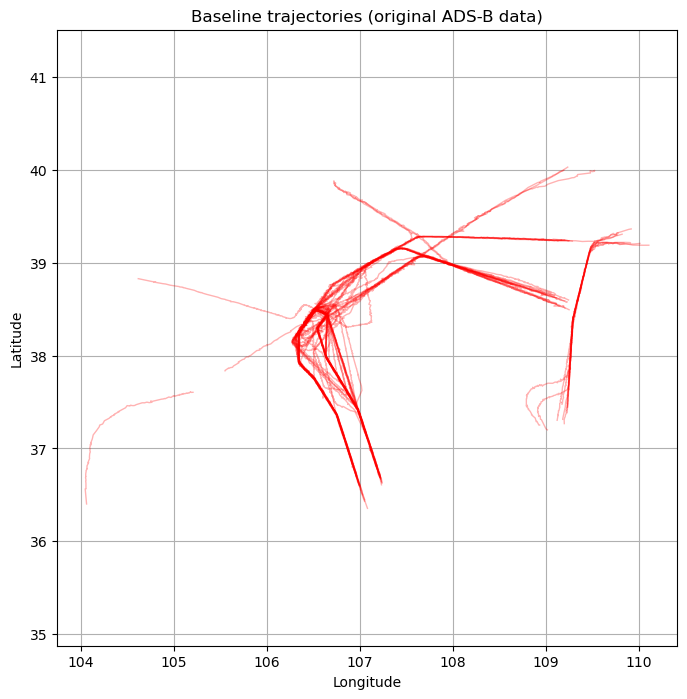

In [28]:
#含噪baseline可视化
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

for track_id, g in noisy_baselines_mixed.groupby('track_id'):
    # plt.plot(
    #     g['lng_original'],
    #     g['lat_original'],
    #     color='black',
    #     alpha=0.3,
    #     linewidth=1
    # )
    plt.plot(
        g['lng_noisy'],
        g['lat_noisy'],
        color='r',
        alpha=0.3,
        linewidth=1
    )
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Baseline trajectories (original ADS-B data)")
plt.axis('equal')
plt.grid(True)
plt.show()



Noise statistics for mixed noise scenario:
  Average noise across all trajectories: 0.05 m
  Maximum noise across all trajectories: 0.19 m
  Overall average noise per point: 0.05 m
  Overall max noise per point: 0.38 m
  Noise std per point: 0.04 m

Visualizing noise effects on sample trajectories...


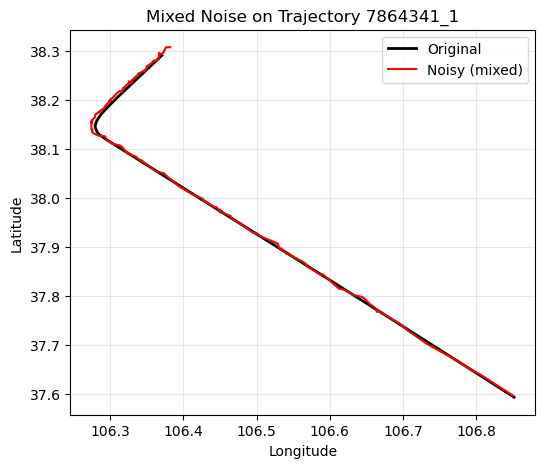

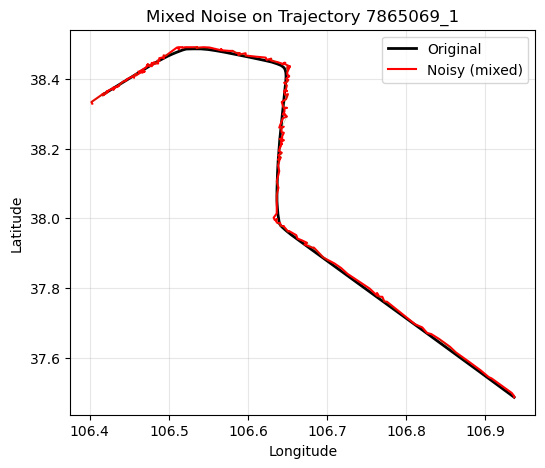

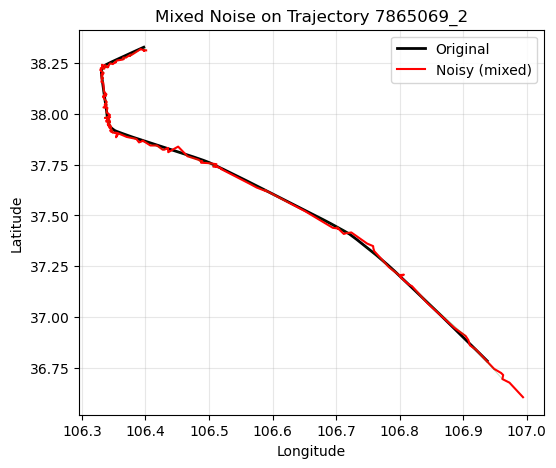

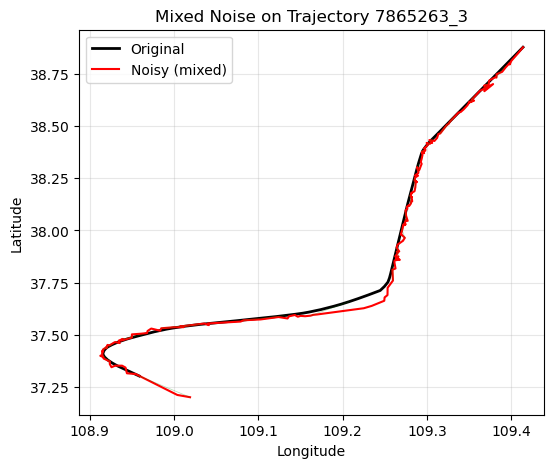

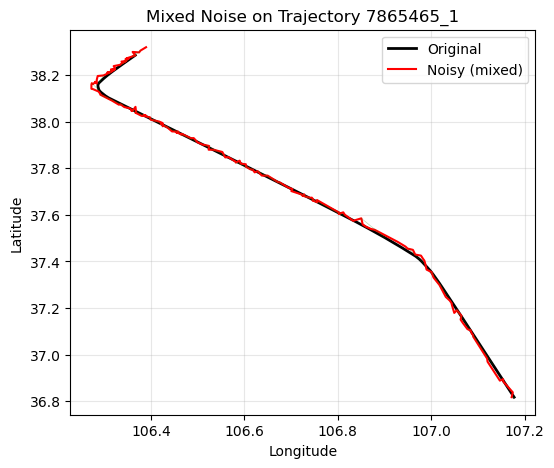

In [34]:
# ==================================================
# 3. 统计噪声信息
# ==================================================
print("\nNoise statistics for mixed noise scenario:")

# 收集所有轨迹的噪声统计
all_avg_noises = []
all_max_noises = []
noise_distributions = []

for track_id, group in noisy_baselines_mixed.groupby('track_id'):
    # 每条轨迹的噪声 magnitude
    noise_magnitudes = np.sqrt(
        (group['lng_noisy'] - group['lng_smoothed'])**2 +
        (group['lat_noisy'] - group['lat_smoothed'])**2
    )
    
    all_avg_noises.append(noise_magnitudes.mean())
    all_max_noises.append(noise_magnitudes.max())
    noise_distributions.extend(noise_magnitudes)

print(f"  Average noise across all trajectories: {np.mean(all_avg_noises):.2f} m")
print(f"  Maximum noise across all trajectories: {np.mean(all_max_noises):.2f} m")
print(f"  Overall average noise per point: {np.mean(noise_distributions):.2f} m")
print(f"  Overall max noise per point: {np.max(noise_distributions):.2f} m")
print(f"  Noise std per point: {np.std(noise_distributions):.2f} m")

# ==================================================
# 4. 可视化几条轨迹的噪声效果
# ==================================================
print("\nVisualizing noise effects on sample trajectories...")

# 选择前5条轨迹进行可视化
n_sample = min(5, noisy_baselines_mixed['track_id'].nunique())
sample_track_ids = noisy_baselines_mixed['track_id'].unique()[:n_sample]

for track_id in sample_track_ids:
    track_clean = baseline_df[baseline_df['track_id'] == track_id].sort_values('point_idx')
    track_noisy = noisy_baselines_mixed[noisy_baselines_mixed['track_id'] == track_id].sort_values('point_idx')

    visualize_noisy_trajectories(
        track_clean,
        track_noisy,
        title=f"Mixed Noise on Trajectory {track_id}"
    )


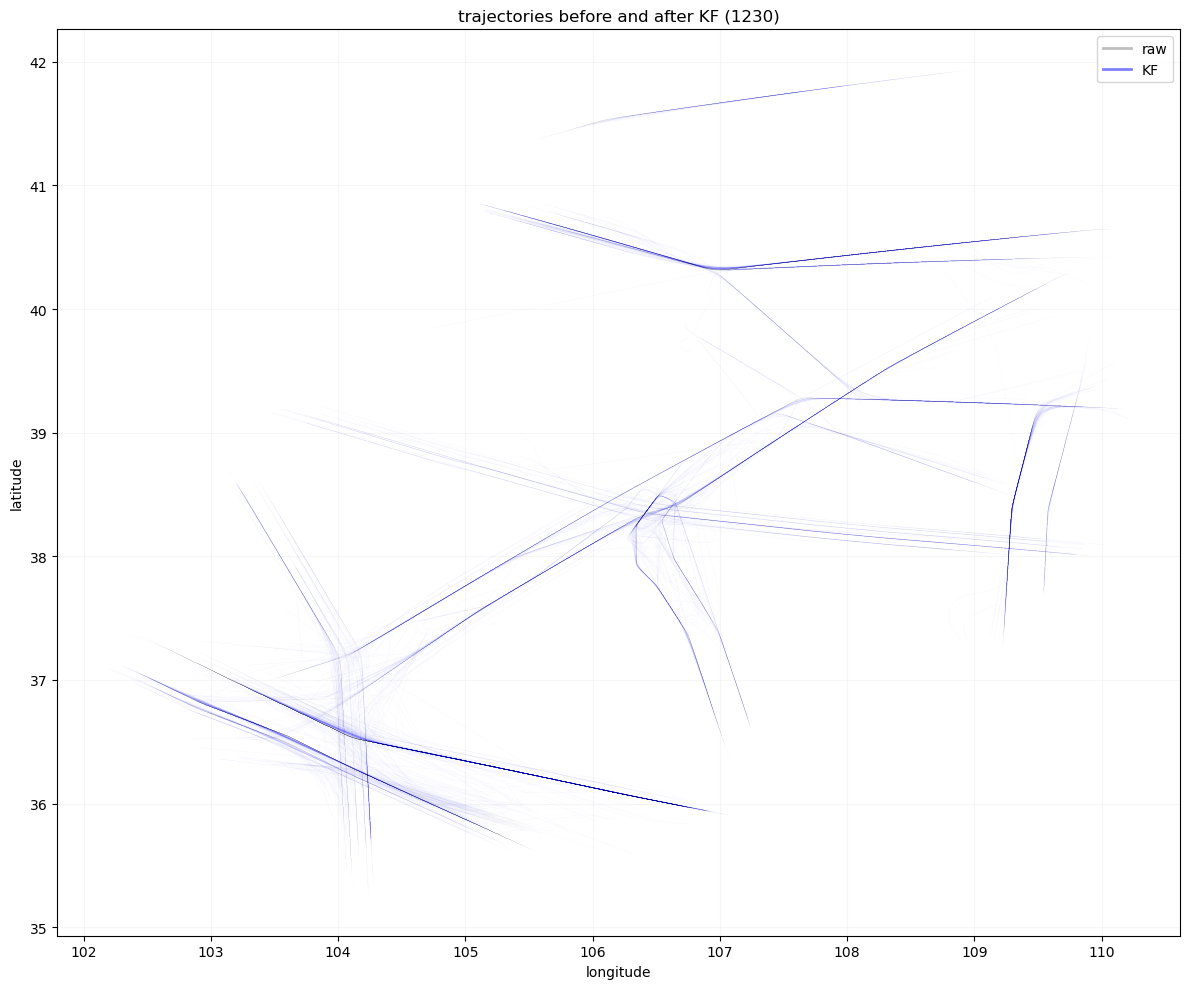

In [30]:
# ==================================================
# 可视化2：叠加显示原始和平滑轨迹
# ==================================================
fig2, ax3 = plt.subplots(figsize=(12, 10))

# 使用更低的透明度来区分重叠轨迹
alpha_overlay_raw = max(0.005, 0.3 / np.sqrt(len(all_tracks_results)))
alpha_overlay_smooth = max(0.01, 0.5 / np.sqrt(len(all_tracks_results)))

# 绘制原始轨迹（灰色）
for track_data in all_tracks_results:
    ax3.plot(track_data['lng_original'], track_data['lat_original'], 
             'gray', alpha=alpha_overlay_raw, linewidth=0.3, label='_nolegend_')

# 绘制平滑轨迹（蓝色）
for track_data in all_tracks_results:
    ax3.plot(track_data['lng_smoothed'], track_data['lat_smoothed'], 
             'blue', alpha=alpha_overlay_smooth, linewidth=0.5, label='_nolegend_')

# 创建图例元素
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='gray', alpha=0.5, lw=2, label='raw'),
    Line2D([0], [0], color='blue', alpha=0.5, lw=2, label='KF')
]

ax3.legend(handles=legend_elements, loc='upper right')
ax3.set_xlabel('longitude')
ax3.set_ylabel('latitude')
ax3.set_title(f'trajectories before and after KF ({len(all_tracks_results)})')
ax3.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()



In [40]:
# 将含噪的baseline数据注入KF中
# =========================================================
# One-cell notebook code: Noisify + Recon(Noisy) + Recon(Clean)
# - Input trajectories assumed normalized to [0,1]
# - Uses your saved "best flights" CSV to pick trajectories
# - Reconstructs from NOISY and from ORIGINAL (CLEAN)
# =========================================================
# def run_kf_on_trajectory(df_track, obs_lng_col, obs_lat_col):
#     """
#     对单条轨迹运行 KF
#     obs_lng_col / obs_lat_col 决定观测来自哪里
#     """

#     # reset index
#     df_track = df_track.sort_values("point_idx").reset_index(drop=True)

#     # 基准点
#     lat0 = df_track[obs_lat_col].iloc[0]
#     lng0 = df_track[obs_lng_col].iloc[0]
#     lat0_rad = np.radians(lat0)

#     m_per_deg_lat = 111000
#     m_per_deg_lng = 111000 * np.cos(lat0_rad)

#     # 观测坐标（⚠ noisy or original）
#     x_obs = (df_track[obs_lng_col] - lng0) * m_per_deg_lng
#     y_obs = (df_track[obs_lat_col] - lat0) * m_per_deg_lat

#     # dt（如果没有就用 1）
#     if "dt" in df_track.columns:
#         dt_series = df_track["dt"].bfill()
#     else:
#         dt_series = np.ones(len(df_track))
    
#     # KF
#     kf = KalmanFilter(dim_x=2, dim_z=2)
#     kf.F = np.eye(2)
#     kf.H = np.eye(2)
#     kf.P *= 10
#     kf.R = np.eye(2) * 25
#     kf.Q = np.eye(2) * 1
#     kf.x = np.array([[x_obs.iloc[0]], [y_obs.iloc[0]]])

#     xs, ys = [], []

#     for i in range(len(df_track)):
#         dt = dt_series.iloc[i]
#         kf.B = np.array([[dt, 0], [0, dt]])
#         u = np.zeros((2, 1))  # ⚠ baseline/noisy 都保持一致
#         kf.predict(u=u)

#         z = np.array([x_obs.iloc[i], y_obs.iloc[i]])
#         kf.update(z)

#         xs.append(kf.x[0, 0])
#         ys.append(kf.x[1, 0])

#     # 转回经纬度
#     lng_kf = lng0 + np.array(xs) / m_per_deg_lng
#     lat_kf = lat0 + np.array(ys) / m_per_deg_lat

#     return lng_kf, lat_kf

def run_kf_on_trajectory(df_track, obs_lng_col, obs_lat_col):
    """
    对单条轨迹运行 KF
    obs_lng_col / obs_lat_col 决定观测来自哪里
    """

    # reset index
    df_track = df_track.sort_values("point_idx").reset_index(drop=True)

    # 基准点
    lat0 = df_track[obs_lat_col].iloc[0]
    lng0 = df_track[obs_lng_col].iloc[0]
    lat0_rad = np.radians(lat0)

    m_per_deg_lat = 111000
    m_per_deg_lng = 111000 * np.cos(lat0_rad)

    # 观测坐标（⚠ noisy or original）
    x_obs = (df_track[obs_lng_col] - lng0) * m_per_deg_lng
    y_obs = (df_track[obs_lat_col] - lat0) * m_per_deg_lat

    # dt（如果没有就用 1）
    if "dt" in df_track.columns:
        dt_series = df_track["dt"].bfill().to_numpy()  # 转为 ndarray，统一索引访问
    else:
        dt_series = np.ones(len(df_track))
    
    # KF
    kf = KalmanFilter(dim_x=2, dim_z=2)
    kf.F = np.eye(2)
    kf.H = np.eye(2)
    kf.P *= 10
    kf.R = np.eye(2) * 25
    kf.Q = np.eye(2) * 1
    kf.x = np.array([[x_obs.iloc[0]], [y_obs.iloc[0]]])

    xs, ys = [], []

    for i in range(len(df_track)):
        dt = dt_series[i]  # ✅ 使用索引访问
        kf.B = np.array([[dt, 0], [0, dt]])
        u = np.zeros((2, 1))  # ⚠ baseline/noisy 都保持一致
        kf.predict(u=u)

        z = np.array([x_obs.iloc[i], y_obs.iloc[i]])
        kf.update(z)

        xs.append(kf.x[0, 0])
        ys.append(kf.x[1, 0])

    # 转回经纬度
    lng_kf = lng0 + np.array(xs) / m_per_deg_lng
    lat_kf = lat0 + np.array(ys) / m_per_deg_lat

    return lng_kf, lat_kf

kf_results_noisy = []

for track_id, group in noisy_baselines_mixed.groupby("track_id"):
    lng_kf, lat_kf = run_kf_on_trajectory(
        group,
        obs_lng_col="lng_noisy",
        obs_lat_col="lat_noisy"
    )

    group = group.copy()
    group["lng_kf_noisy"] = lng_kf
    group["lat_kf_noisy"] = lat_kf

    kf_results_noisy.append(group)

kf_noisy_df = pd.concat(kf_results_noisy, ignore_index=True)


In [ ]:
# KF robustness
error_noisy = np.sqrt(
    (kf_noisy_df["lng_kf_noisy"] - kf_noisy_df["lng_original"])**2 +
    (kf_noisy_df["lat_kf_noisy"] - kf_noisy_df["lat_original"])**2
)
# KF 修正效果
error_raw = np.sqrt(
    (kf_noisy_df["lng_noisy"] - kf_noisy_df["lng_original"])**2 +
    (kf_noisy_df["lat_noisy"] - kf_noisy_df["lat_original"])**2
)



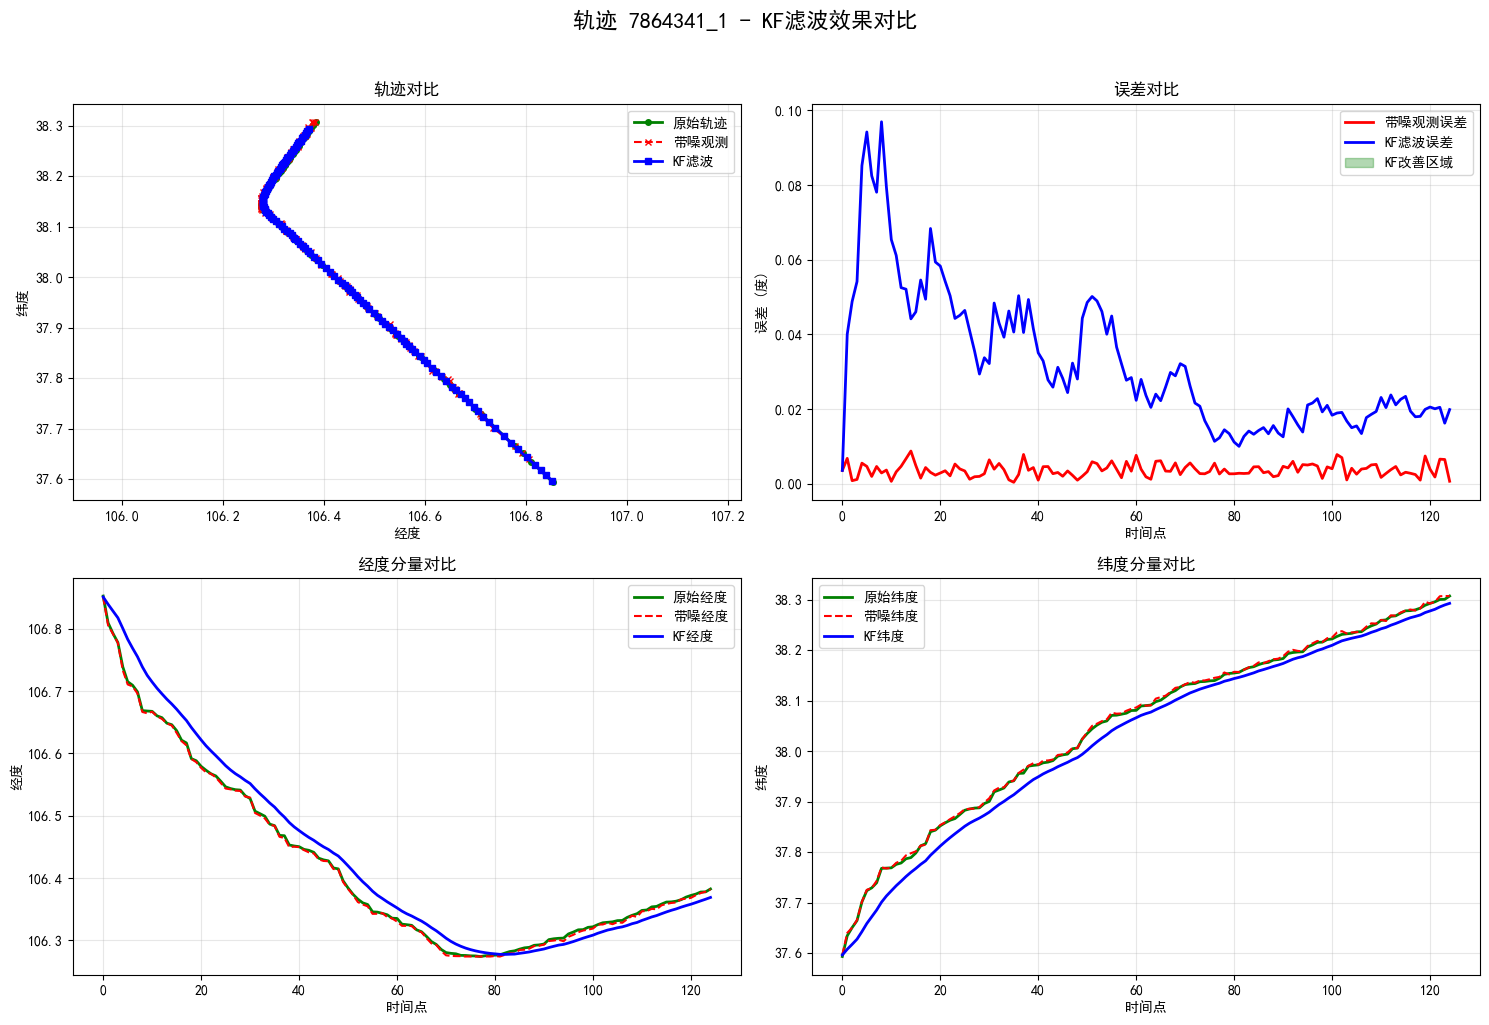

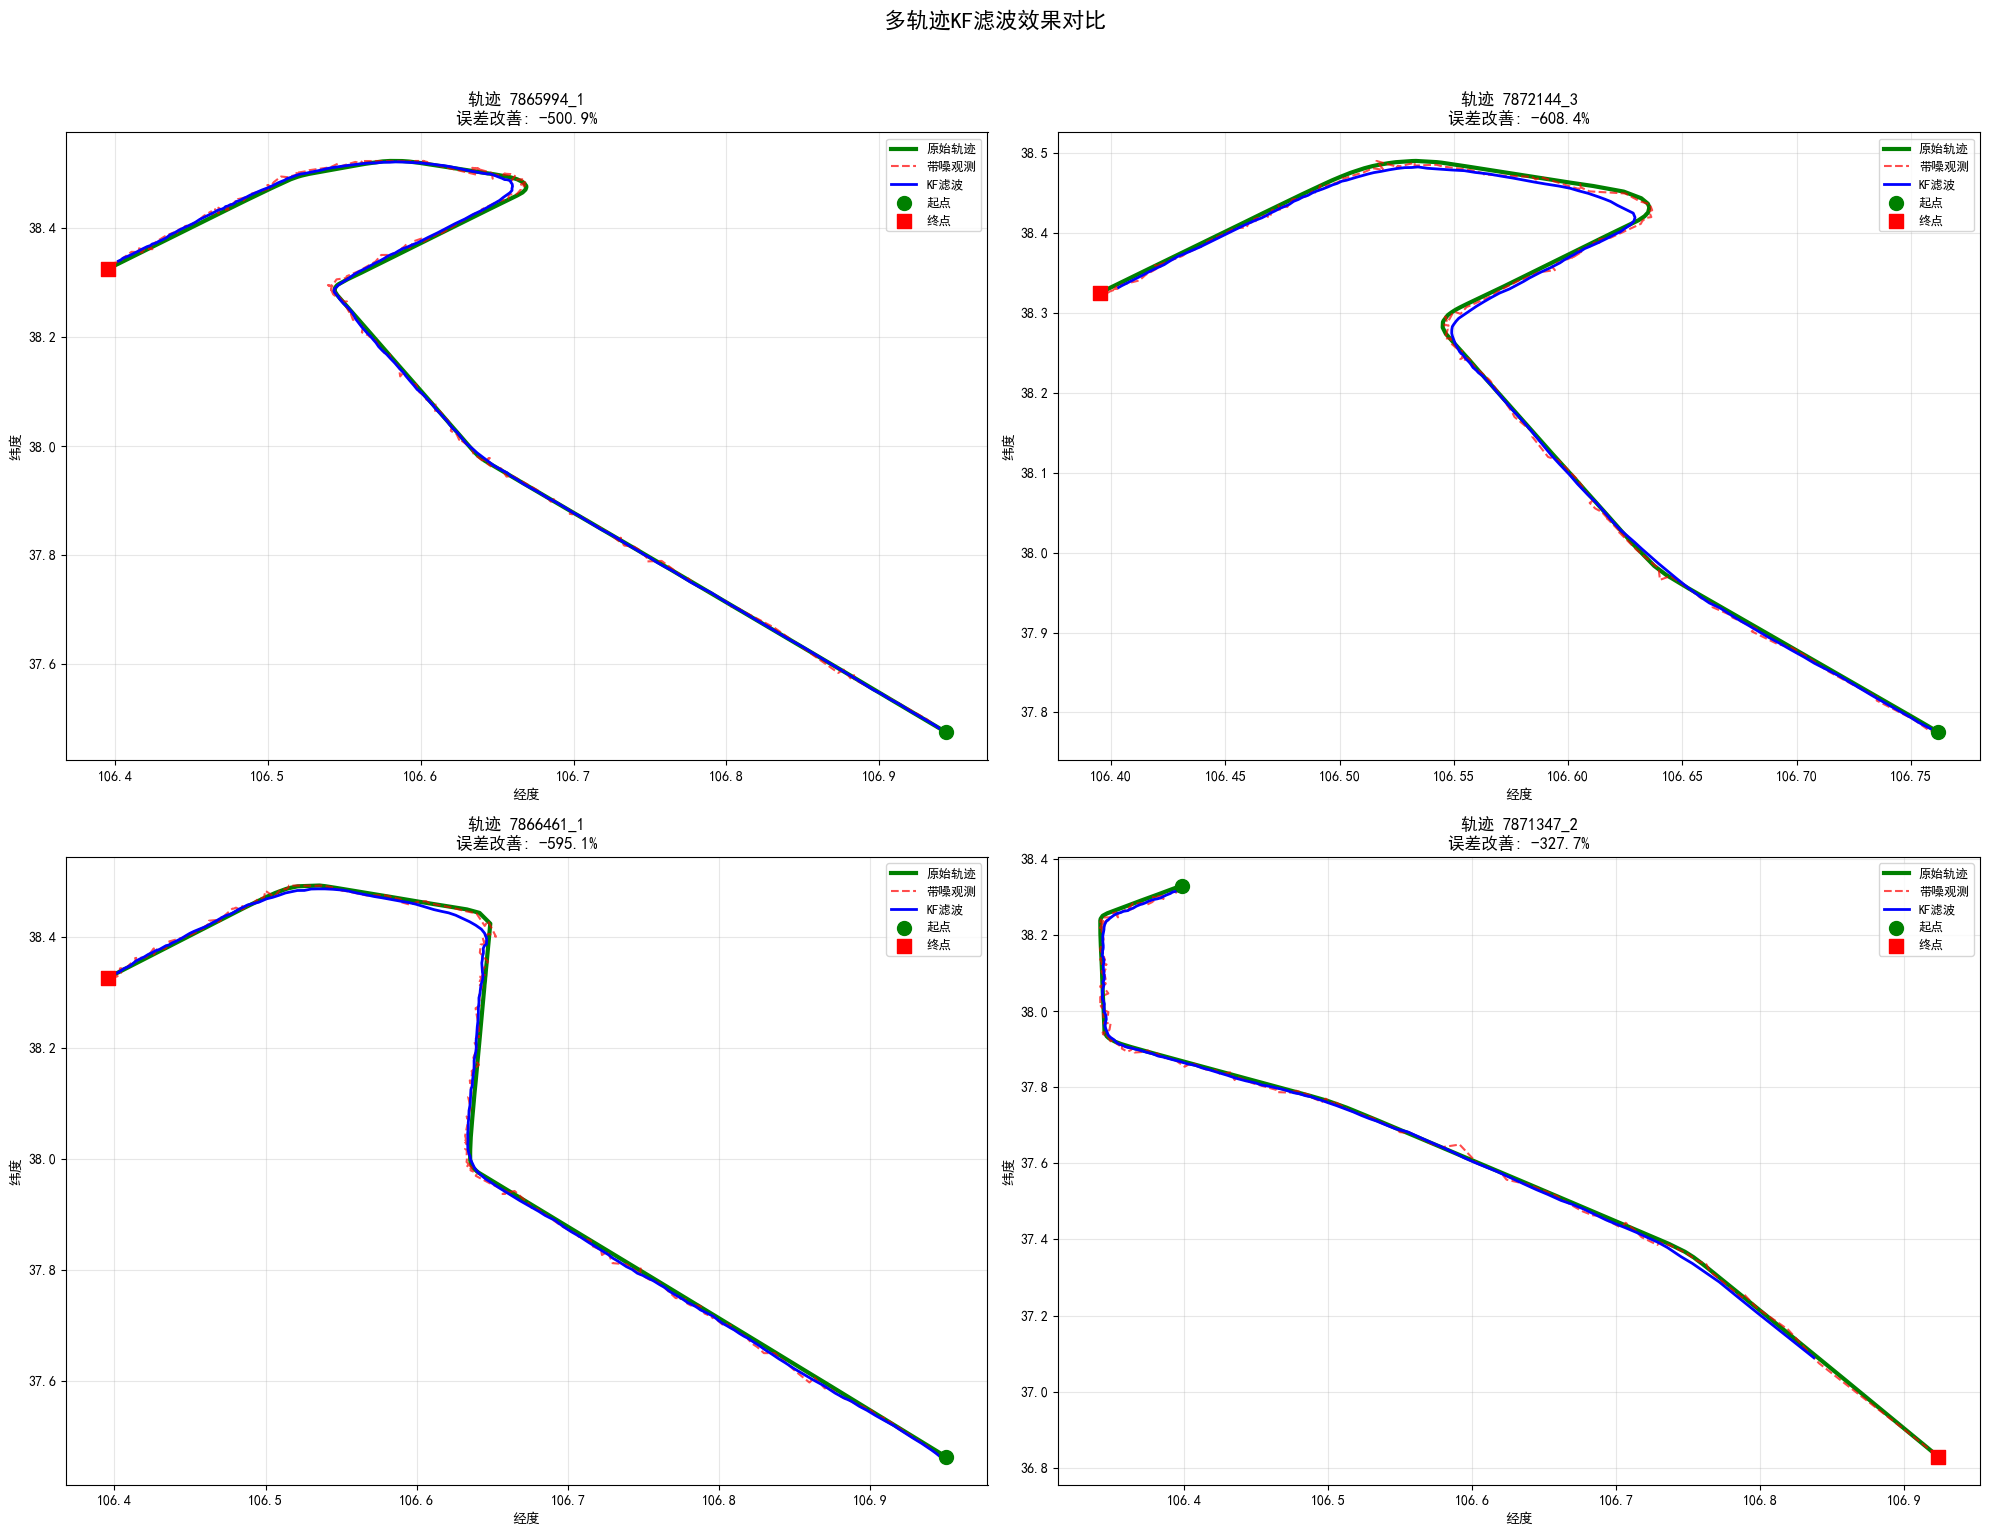

C:\Users\93176\AppData\Local\Temp\ipykernel_15688\1471406928.py:267: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax6.boxplot(error_data, labels=['带噪观测', 'KF滤波'],


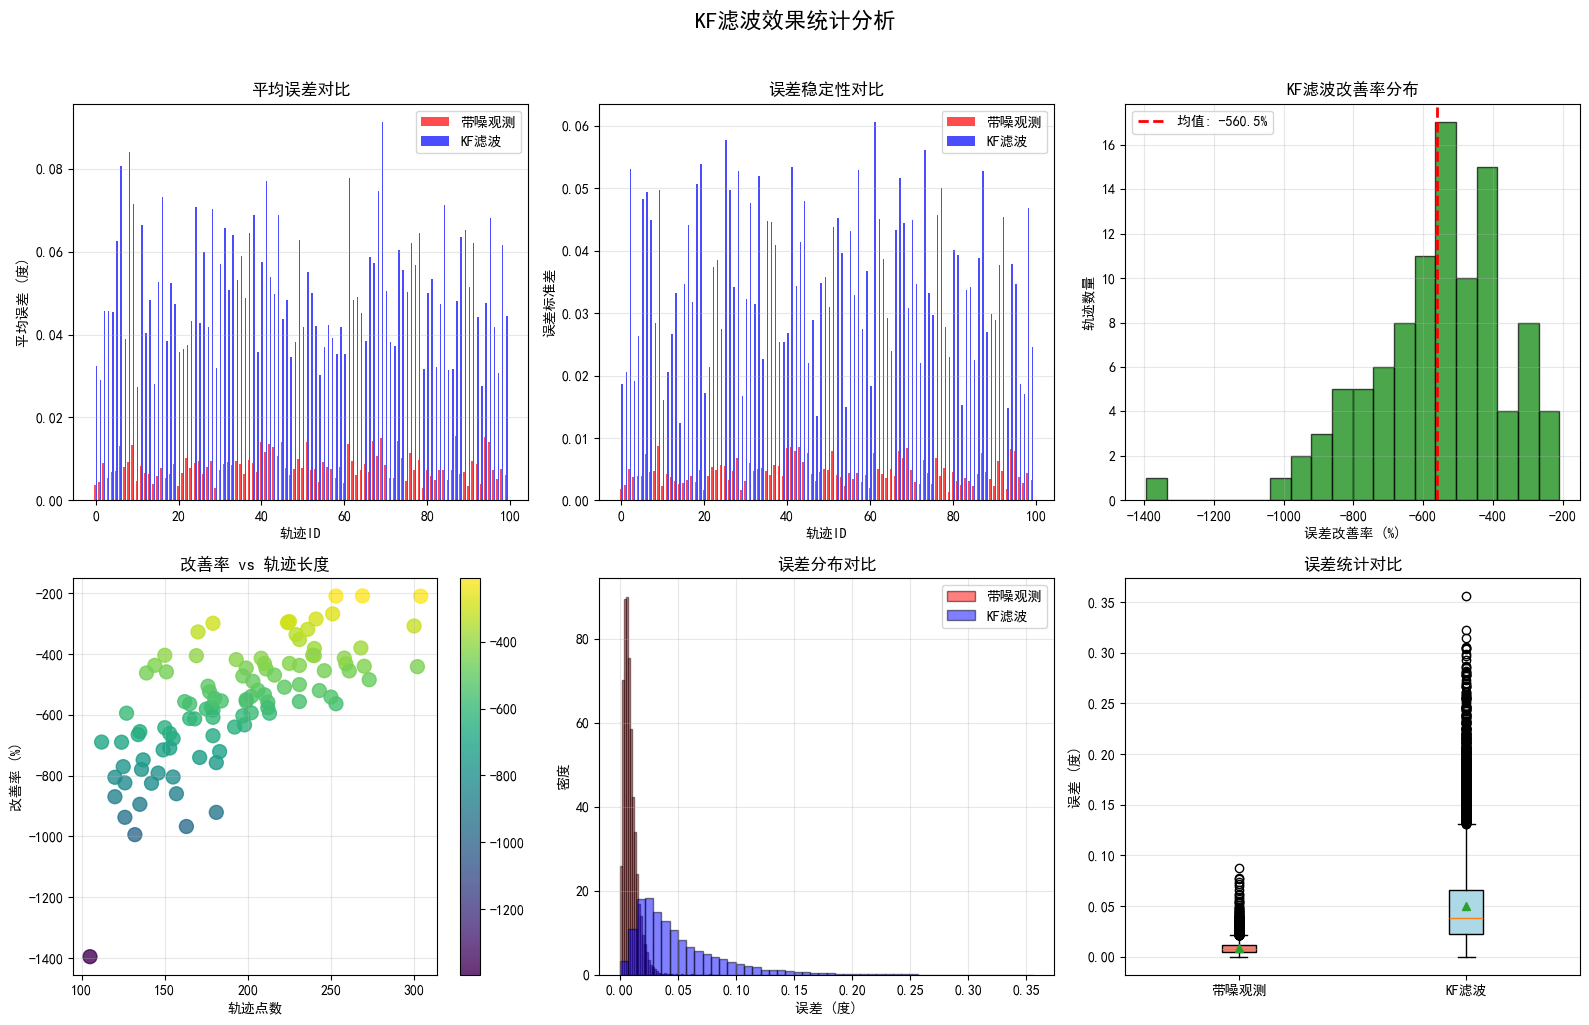

=== KF滤波效果统计摘要 ===
总轨迹数: 100
总点数: 19310
平均误差改善率: -560.50%
最大改善率: -209.35%
最小改善率: -1395.61%


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import numpy as np

# 设置中文字体（如果需要）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 1. 轨迹对比图（单个轨迹）
def plot_single_track_comparison(track_id, df, figsize=(15, 10)):
    """
    可视化单个轨迹的原始、带噪和KF滤波结果
    """
    track_data = df[df["track_id"] == track_id].copy()
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'轨迹 {track_id} - KF滤波效果对比', fontsize=16, y=1.02)
    
    # 1.1 经纬度轨迹对比
    ax1 = axes[0, 0]
    ax1.plot(track_data["lng_original"], track_data["lat_original"], 
             'g-', linewidth=2, label='原始轨迹', marker='o', markersize=4)
    ax1.plot(track_data["lng_noisy"], track_data["lat_noisy"], 
             'r--', linewidth=1.5, label='带噪观测', marker='x', markersize=4)
    ax1.plot(track_data["lng_kf_noisy"], track_data["lat_kf_noisy"], 
             'b-', linewidth=2, label='KF滤波', marker='s', markersize=4)
    ax1.set_xlabel('经度')
    ax1.set_ylabel('纬度')
    ax1.set_title('轨迹对比')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # 1.2 误差随时间变化
    ax2 = axes[0, 1]
    time_points = np.arange(len(track_data))
    error_raw = np.sqrt(
        (track_data["lng_noisy"] - track_data["lng_original"])**2 +
        (track_data["lat_noisy"] - track_data["lat_original"])**2
    )
    error_kf = np.sqrt(
        (track_data["lng_kf_noisy"] - track_data["lng_original"])**2 +
        (track_data["lat_kf_noisy"] - track_data["lat_original"])**2
    )
    
    ax2.plot(time_points, error_raw, 'r-', label='带噪观测误差', linewidth=2)
    ax2.plot(time_points, error_kf, 'b-', label='KF滤波误差', linewidth=2)
    ax2.fill_between(time_points, error_raw, error_kf, 
                     where=(error_kf < error_raw), color='green', alpha=0.3, label='KF改善区域')
    ax2.set_xlabel('时间点')
    ax2.set_ylabel('误差 (度)')
    ax2.set_title('误差对比')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 1.3 经度分量对比
    ax3 = axes[1, 0]
    ax3.plot(time_points, track_data["lng_original"], 'g-', label='原始经度', linewidth=2)
    ax3.plot(time_points, track_data["lng_noisy"], 'r--', label='带噪经度', linewidth=1.5)
    ax3.plot(time_points, track_data["lng_kf_noisy"], 'b-', label='KF经度', linewidth=2)
    ax3.set_xlabel('时间点')
    ax3.set_ylabel('经度')
    ax3.set_title('经度分量对比')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 1.4 纬度分量对比
    ax4 = axes[1, 1]
    ax4.plot(time_points, track_data["lat_original"], 'g-', label='原始纬度', linewidth=2)
    ax4.plot(time_points, track_data["lat_noisy"], 'r--', label='带噪纬度', linewidth=1.5)
    ax4.plot(time_points, track_data["lat_kf_noisy"], 'b-', label='KF纬度', linewidth=2)
    ax4.set_xlabel('时间点')
    ax4.set_ylabel('纬度')
    ax4.set_title('纬度分量对比')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# 2. 多轨迹对比图（选择几个有代表性的轨迹）
def plot_multiple_tracks(df, track_ids=None, n_tracks=4, figsize=(20, 15)):
    """
    可视化多个轨迹的KF滤波效果
    """
    if track_ids is None:
        # 随机选择几个轨迹，或者选择误差变化最大的
        unique_tracks = df["track_id"].unique()
        if len(unique_tracks) > n_tracks:
            # 选择误差改善最明显的轨迹
            track_errors = []
            for track_id in unique_tracks:
                track_data = df[df["track_id"] == track_id]
                error_raw = np.sqrt(
                    (track_data["lng_noisy"] - track_data["lng_original"])**2 +
                    (track_data["lat_noisy"] - track_data["lat_original"])**2
                ).mean()
                error_kf = np.sqrt(
                    (track_data["lng_kf_noisy"] - track_data["lng_original"])**2 +
                    (track_data["lat_kf_noisy"] - track_data["lat_original"])**2
                ).mean()
                improvement = error_raw - error_kf
                track_errors.append((track_id, improvement))
            
            track_errors.sort(key=lambda x: x[1], reverse=True)
            track_ids = [t[0] for t in track_errors[:n_tracks]]
        else:
            track_ids = unique_tracks[:n_tracks]
    
    n_rows = int(np.ceil(n_tracks / 2))
    n_cols = 2 if n_tracks > 1 else 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_tracks > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for idx, track_id in enumerate(track_ids[:n_tracks]):
        if idx >= len(axes):
            break
            
        track_data = df[df["track_id"] == track_id]
        ax = axes[idx]
        
        ax.plot(track_data["lng_original"], track_data["lat_original"], 
                'g-', linewidth=3, label='原始轨迹')
        ax.plot(track_data["lng_noisy"], track_data["lat_noisy"], 
                'r--', linewidth=1.5, label='带噪观测', alpha=0.7)
        ax.plot(track_data["lng_kf_noisy"], track_data["lat_kf_noisy"], 
                'b-', linewidth=2, label='KF滤波')
        
        # 标记起点和终点
        ax.scatter(track_data["lng_original"].iloc[0], track_data["lat_original"].iloc[0],
                  c='green', s=100, marker='o', label='起点', zorder=5)
        ax.scatter(track_data["lng_original"].iloc[-1], track_data["lat_original"].iloc[-1],
                  c='red', s=100, marker='s', label='终点', zorder=5)
        
        # 计算误差改善
        error_raw = np.sqrt(
            (track_data["lng_noisy"] - track_data["lng_original"])**2 +
            (track_data["lat_noisy"] - track_data["lat_original"])**2
        ).mean()
        error_kf = np.sqrt(
            (track_data["lng_kf_noisy"] - track_data["lng_original"])**2 +
            (track_data["lat_kf_noisy"] - track_data["lat_original"])**2
        ).mean()
        improvement = ((error_raw - error_kf) / error_raw * 100)
        
        ax.set_title(f'轨迹 {track_id}\n误差改善: {improvement:.1f}%', fontsize=12)
        ax.set_xlabel('经度')
        ax.set_ylabel('纬度')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', fontsize=9)
    
    # 隐藏多余的子图
    for idx in range(len(track_ids), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('多轨迹KF滤波效果对比', fontsize=16, y=1.02)
    plt.tight_layout()
    return fig

# 3. 统计结果可视化
def plot_statistical_results(df, figsize=(16, 10)):
    """
    可视化所有轨迹的统计结果
    """
    # 按轨迹分组计算统计量
    stats = []
    for track_id, group in df.groupby("track_id"):
        error_raw = np.sqrt(
            (group["lng_noisy"] - group["lng_original"])**2 +
            (group["lat_noisy"] - group["lat_original"])**2
        )
        error_kf = np.sqrt(
            (group["lng_kf_noisy"] - group["lng_original"])**2 +
            (group["lat_kf_noisy"] - group["lat_original"])**2
        )
        
        stats.append({
            'track_id': track_id,
            'raw_mean': error_raw.mean(),
            'raw_std': error_raw.std(),
            'kf_mean': error_kf.mean(),
            'kf_std': error_kf.std(),
            'improvement': (error_raw.mean() - error_kf.mean()) / error_raw.mean() * 100,
            'points': len(group)
        })
    
    stats_df = pd.DataFrame(stats)
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # 3.1 误差均值对比
    ax1 = axes[0, 0]
    x_pos = np.arange(len(stats_df))
    width = 0.35
    ax1.bar(x_pos - width/2, stats_df['raw_mean'], width, 
            label='带噪观测', color='r', alpha=0.7)
    ax1.bar(x_pos + width/2, stats_df['kf_mean'], width, 
            label='KF滤波', color='b', alpha=0.7)
    ax1.set_xlabel('轨迹ID')
    ax1.set_ylabel('平均误差 (度)')
    ax1.set_title('平均误差对比')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 3.2 误差标准差对比
    ax2 = axes[0, 1]
    ax2.bar(x_pos - width/2, stats_df['raw_std'], width, 
            label='带噪观测', color='r', alpha=0.7)
    ax2.bar(x_pos + width/2, stats_df['kf_std'], width, 
            label='KF滤波', color='b', alpha=0.7)
    ax2.set_xlabel('轨迹ID')
    ax2.set_ylabel('误差标准差')
    ax2.set_title('误差稳定性对比')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3.3 改善率分布
    ax3 = axes[0, 2]
    ax3.hist(stats_df['improvement'], bins=20, edgecolor='black', alpha=0.7, color='green')
    ax3.axvline(stats_df['improvement'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'均值: {stats_df["improvement"].mean():.1f}%')
    ax3.set_xlabel('误差改善率 (%)')
    ax3.set_ylabel('轨迹数量')
    ax3.set_title('KF滤波改善率分布')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 3.4 改善率与轨迹长度关系
    ax4 = axes[1, 0]
    scatter = ax4.scatter(stats_df['points'], stats_df['improvement'], 
                         c=stats_df['improvement'], cmap='viridis', s=100, alpha=0.8)
    ax4.set_xlabel('轨迹点数')
    ax4.set_ylabel('改善率 (%)')
    ax4.set_title('改善率 vs 轨迹长度')
    plt.colorbar(scatter, ax=ax4)
    ax4.grid(True, alpha=0.3)
    
    # 3.5 误差累计分布
    ax5 = axes[1, 1]
    all_errors_raw = np.sqrt(
        (df["lng_noisy"] - df["lng_original"])**2 +
        (df["lat_noisy"] - df["lat_original"])**2
    )
    all_errors_kf = np.sqrt(
        (df["lng_kf_noisy"] - df["lng_original"])**2 +
        (df["lat_kf_noisy"] - df["lat_original"])**2
    )
    
    ax5.hist(all_errors_raw, bins=50, alpha=0.5, label='带噪观测', 
             color='red', density=True, edgecolor='black')
    ax5.hist(all_errors_kf, bins=50, alpha=0.5, label='KF滤波', 
             color='blue', density=True, edgecolor='black')
    ax5.set_xlabel('误差 (度)')
    ax5.set_ylabel('密度')
    ax5.set_title('误差分布对比')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 3.6 箱线图对比
    ax6 = axes[1, 2]
    error_data = [all_errors_raw, all_errors_kf]
    bp = ax6.boxplot(error_data, labels=['带噪观测', 'KF滤波'], 
                     patch_artist=True, showmeans=True)
    
    # 设置箱线图颜色
    colors = ['lightcoral', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax6.set_ylabel('误差 (度)')
    ax6.set_title('误差统计对比')
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('KF滤波效果统计分析', fontsize=16, y=1.02)
    plt.tight_layout()
    
    return fig, stats_df

# 4. 交互式可视化（使用plotly，可选）
def plot_interactive_trajectories(df, track_ids=None):
    """
    使用plotly创建交互式可视化
    需要安装：pip install plotly
    """
    try:
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
        
        if track_ids is None:
            track_ids = df["track_id"].unique()[:5]  # 默认显示前5个轨迹
        
        fig = make_subplots(
            rows=len(track_ids), cols=1,
            subplot_titles=[f'轨迹 {tid}' for tid in track_ids],
            vertical_spacing=0.05
        )
        
        for idx, track_id in enumerate(track_ids):
            row = idx + 1
            track_data = df[df["track_id"] == track_id]
            
            # 原始轨迹
            fig.add_trace(
                go.Scatter(
                    x=track_data["lng_original"],
                    y=track_data["lat_original"],
                    mode='lines+markers',
                    name='原始轨迹',
                    line=dict(color='green', width=3),
                    marker=dict(size=6)
                ),
                row=row, col=1
            )
            
            # 带噪观测
            fig.add_trace(
                go.Scatter(
                    x=track_data["lng_noisy"],
                    y=track_data["lat_noisy"],
                    mode='lines+markers',
                    name='带噪观测',
                    line=dict(color='red', width=1.5, dash='dash'),
                    marker=dict(size=4, symbol='x')
                ),
                row=row, col=1
            )
            
            # KF滤波结果
            fig.add_trace(
                go.Scplot_single_track_comparison(
                    x=track_data["lng_kf_noisy"],
                    y=track_data["lat_kf_noisy"],
                    mode='lines+markers',
                    name='KF滤波',
                    line=dict(color='blue', width=2),
                    marker=dict(size=5, symbol='square')
                ),
                row=row, col=1
            )
            
            # 更新布局
            fig.update_xaxes(title_text="经度", row=row, col=1)
            fig.update_yaxes(title_text="纬度", row=row, col=1)
        
        fig.update_layout(
            height=300 * len(track_ids),
            title_text="KF滤波效果交互式可视化",
            showlegend=True,
            hovermode='closest'
        )
        
        return fig
        
    except ImportError:
        print("Plotly未安装，使用 pip install plotly 安装")
        return None

# 使用示例
if __name__ == "__main__":
    # 1. 可视化单个轨迹（例如第一个轨迹）
    if len(kf_noisy_df["track_id"].unique()) > 0:
        first_track = kf_noisy_df["track_id"].iloc[0]
        fig1 = plot_single_track_comparison(first_track, kf_noisy_df)
        plt.show()
        
        # 2. 可视化多个轨迹
        fig2 = plot_multiple_tracks(kf_noisy_df, n_tracks=4)
        plt.show()
        
        # 3. 统计结果可视化
        fig3, stats_df = plot_statistical_results(kf_noisy_df)
        plt.show()
        
        # 4. 打印统计摘要
        print("=== KF滤波效果统计摘要 ===")
        print(f"总轨迹数: {len(stats_df)}")
        print(f"总点数: {len(kf_noisy_df)}")
        print(f"平均误差改善率: {stats_df['improvement'].mean():.2f}%")
        print(f"最大改善率: {stats_df['improvement'].max():.2f}%")
        print(f"最小改善率: {stats_df['improvement'].min():.2f}%")
        
        # # 5. 保存结果
        # fig1.savefig('kf_single_track.png', dpi=300, bbox_inches='tight')
        # fig2.savefig('kf_multiple_tracks.png', dpi=300, bbox_inches='tight')
        # fig3.savefig('kf_statistical_results.png', dpi=300, bbox_inches='tight')
        # stats_df.to_csv('kf_performance_stats.csv', index=False)

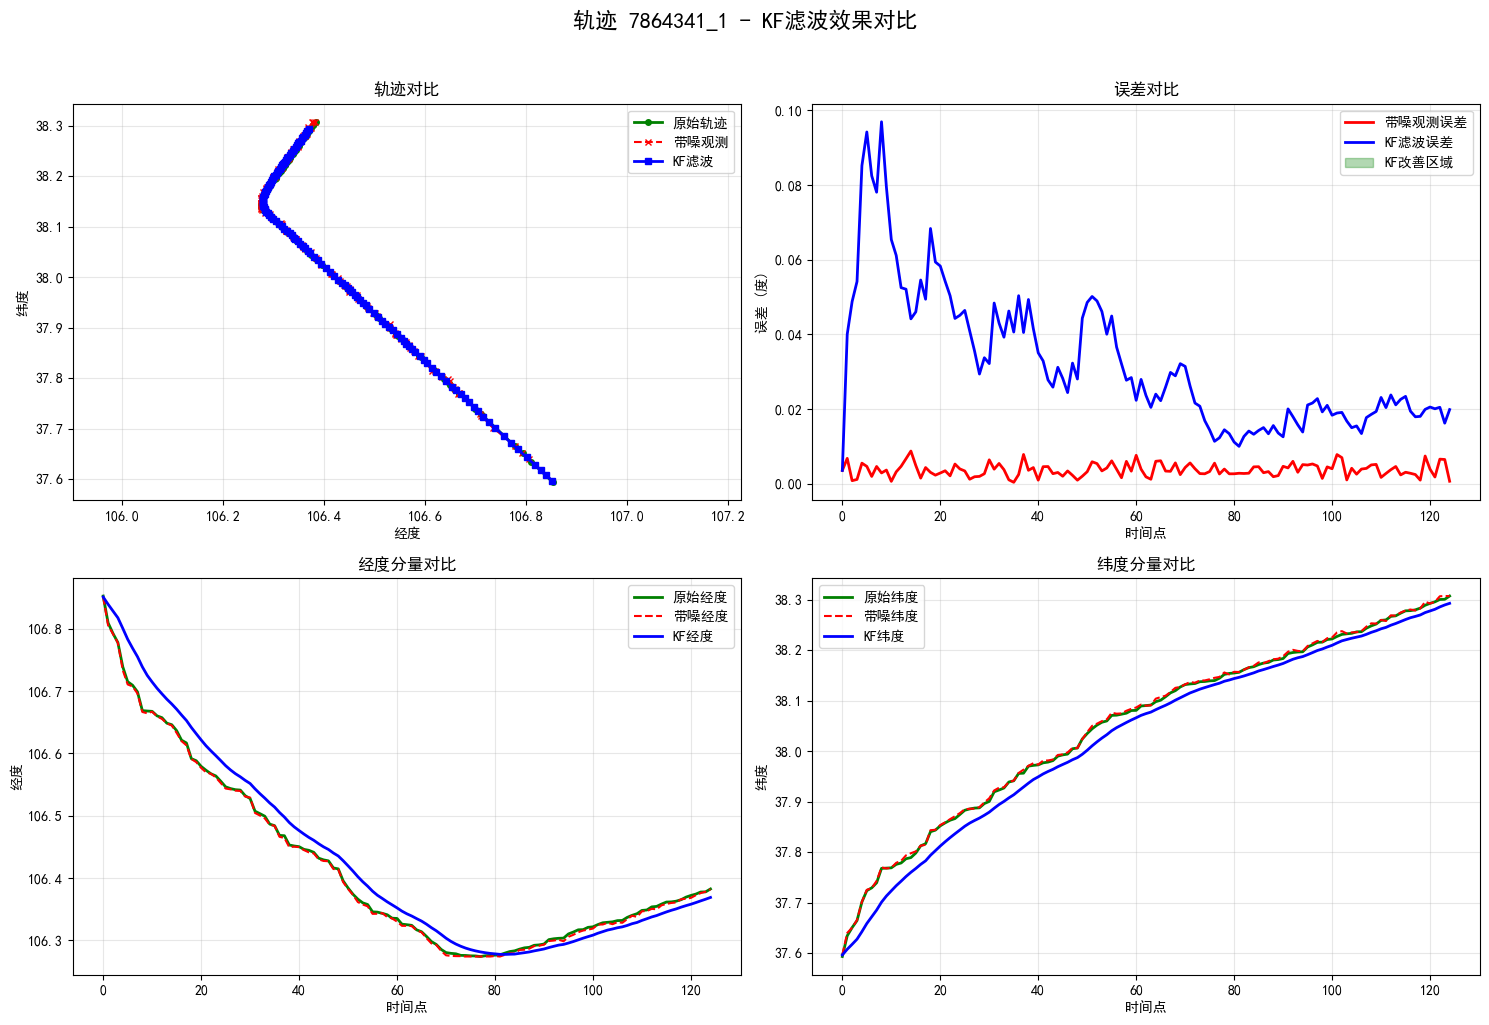

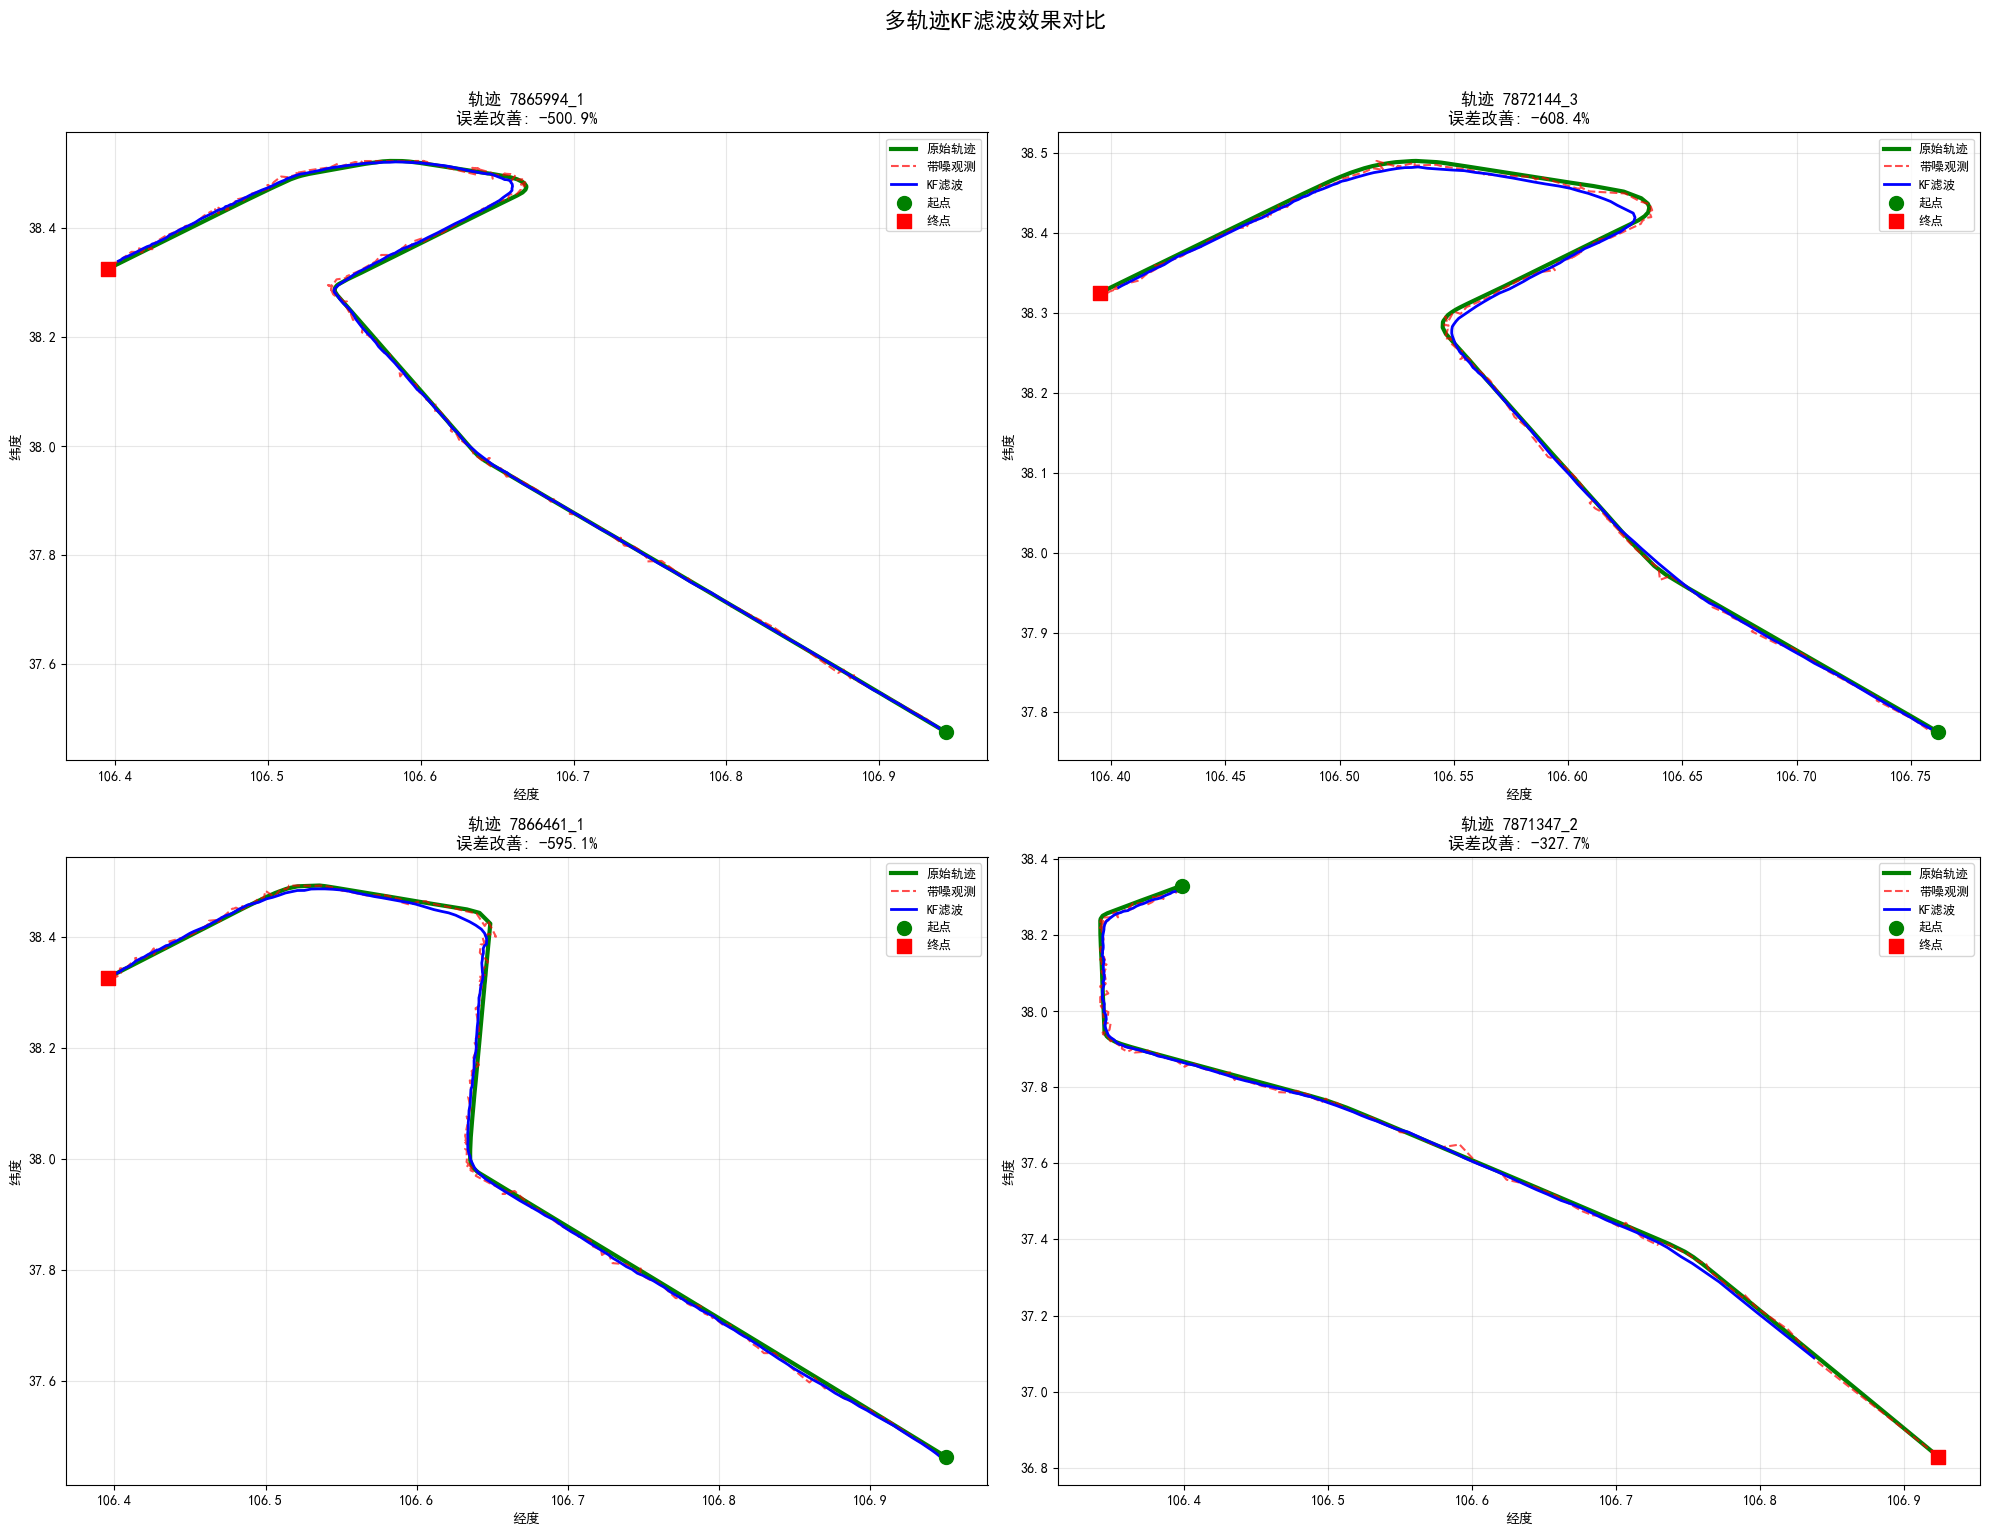

C:\Users\93176\AppData\Local\Temp\ipykernel_15688\1471406928.py:267: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax6.boxplot(error_data, labels=['带噪观测', 'KF滤波'],


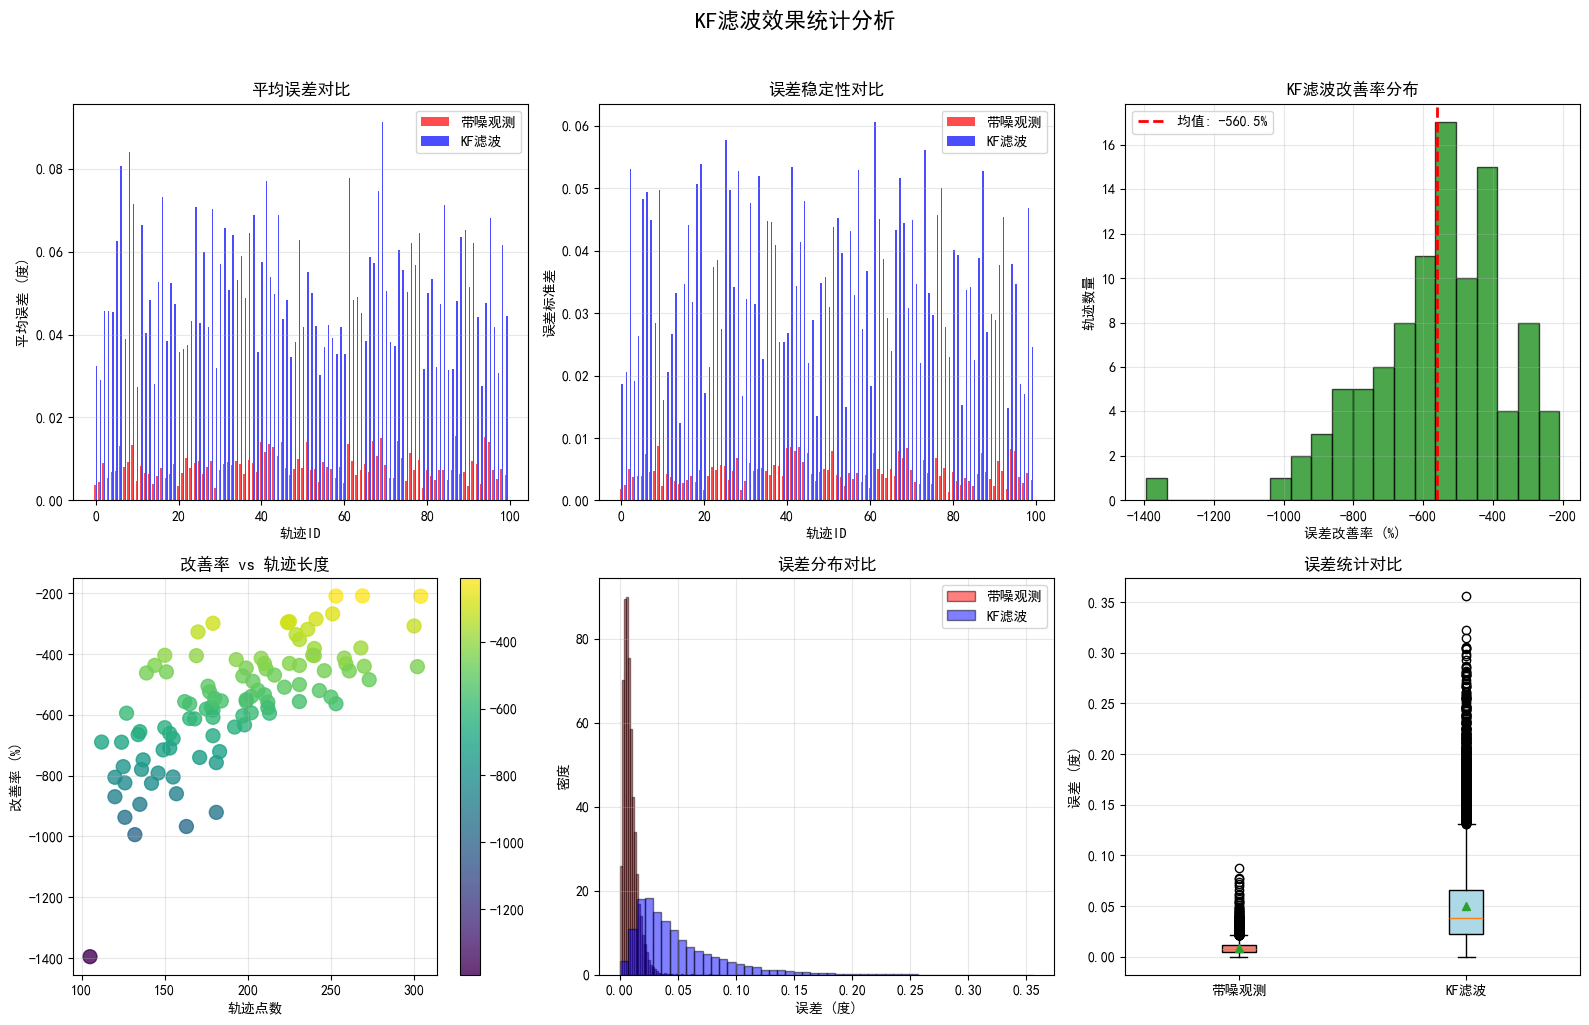

In [44]:
# 可视化第一个轨迹
first_track = kf_noisy_df["track_id"].iloc[0]
fig = plot_single_track_comparison(first_track, kf_noisy_df)
plt.show()

# 可视化多个轨迹
fig = plot_multiple_tracks(kf_noisy_df, n_tracks=4)
plt.show()

# 查看统计结果
fig, stats_df = plot_statistical_results(kf_noisy_df)
plt.show()